In [105]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
warnings.filterwarnings("ignore")

# help function

In [106]:
def trim_and_padding(y):
    time_length = 72000
    if 0 < len(y):
        trimmed, index = librosa.effects.trim(reduced_noise, top_db=20, frame_length=512, hop_length=64)
    if len(y) > time_length:
        y = y[0:time_length]
    else: # pad blank
        padding = time_length - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, time_length - len(y) - offset))
    return y


def Noise_Injection(data,noise_factor=1):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def Shifting_Time(data, sampling_rate=16000, shift_max=100, shift_direction='right'):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif self.shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def Changing_Pitch(data, sampling_rate=16000, pitch_factor = 2):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def Changing_Speed(data, speed_factor=1.5):
    return librosa.effects.time_stretch(data, speed_factor)

aug_method = {}
aug_method[0] = Noise_Injection
aug_method[1] = Shifting_Time
aug_method[2] = Changing_Pitch
aug_method[3] = Changing_Speed

# PATH

In [107]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# EDA

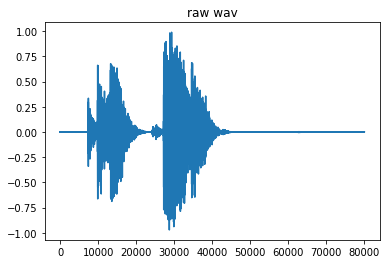

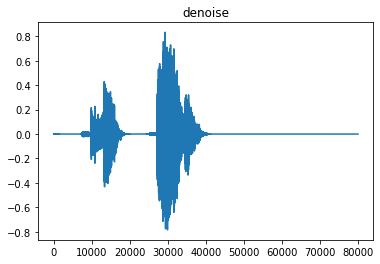

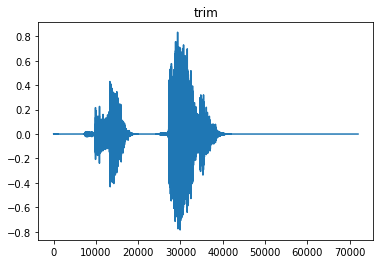

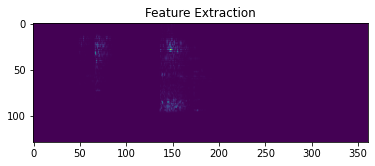

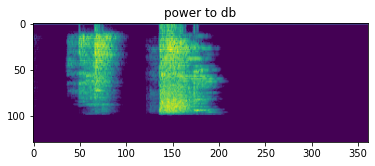

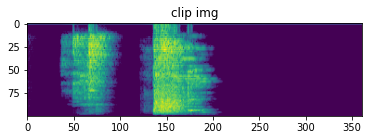

In [108]:
# raw wav
samples, sample_rate = librosa.load(X_train_dir+os.listdir(X_train_dir)[0],sr=16000)
plt.title('raw wav')
plt.plot(samples)
plt.show()

# denoise
noisy_part = samples[0:-1]
reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=noisy_part, verbose=False)
plt.title('denoise')
plt.plot(reduced_noise)
plt.show()

#trim these portions of the waveform
trimmed = trim_and_padding(reduced_noise)
plt.title('trim')
plt.plot(trimmed)
plt.show()

# Feature Extraction
melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
plt.title('Feature Extraction')
plt.imshow(melspectrogram)
plt.show()

# power to db
melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
plt.title('power to db')
plt.imshow(melspectrogram)
plt.show()

# clip img
melspectrogram = melspectrogram[:100,:]
plt.title('clip img')
plt.imshow(melspectrogram)
plt.show()

# preprocessing 

In [109]:
def sample2melspectrogram(samples,sample_rate):
    # denoise
    noisy_part = samples[0:-1]
    reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=noisy_part, verbose=False)
    # trim
    trimmed = trim_and_padding(reduced_noise)
    # Feature Extraction
    melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
    # power to db
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    # clip img
    melspectrogram = melspectrogram[:100,:]
    return melspectrogram

def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
        mel_spectrogram = sample2melspectrogram(samples,sample_rate)
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path)
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

def preprocessing_X_with_Augmentation(wav_dir,aug_method_idx=0):
    files = os.listdir(wav_dir)
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
        aug_method[aug_method_idx](samples)
        mel_spectrogram = sample2melspectrogram(samples,sample_rate)
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
    print('X shape:',X.shape)
    return X

# Load X

In [110]:
X_train = preprocessing_X(X_train_dir)
X_aug0 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=0)
X_aug1 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=1)
X_aug2 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=2)
X_aug3 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=3)
X_train = torch.cat([X_train,X_aug0,X_aug1,X_aug2,X_aug3],dim=0)







  0%|          | 0/1200 [00:00<?, ?it/s]





  0%|          | 1/1200 [00:00<04:27,  4.48it/s]





  0%|          | 2/1200 [00:00<03:58,  5.02it/s]





  0%|          | 3/1200 [00:00<03:43,  5.36it/s]





  0%|          | 4/1200 [00:00<03:34,  5.58it/s]





  0%|          | 5/1200 [00:00<03:39,  5.43it/s]





  0%|          | 6/1200 [00:01<03:36,  5.52it/s]





  1%|          | 7/1200 [00:01<03:25,  5.80it/s]





  1%|          | 8/1200 [00:01<03:21,  5.93it/s]





  1%|          | 9/1200 [00:01<03:18,  6.01it/s]





  1%|          | 10/1200 [00:01<03:11,  6.21it/s]





  1%|          | 11/1200 [00:01<03:15,  6.08it/s]





  1%|          | 12/1200 [00:02<03:12,  6.18it/s]





  1%|          | 13/1200 [00:02<03:11,  6.21it/s]





  1%|          | 14/1200 [00:02<03:07,  6.33it/s]





  1%|▏         | 15/1200 [00:02<03:22,  5.86it/s]





  1%|▏         | 16/1200 [00:02<03:16,  6.02it/s]





  1%|▏         | 17/1200 [00:02<03:07,  6.32it/s]





  2%|▏         | 18/12

  9%|▉         | 112/1200 [00:19<03:04,  5.90it/s]





  9%|▉         | 113/1200 [00:19<03:11,  5.68it/s]





 10%|▉         | 114/1200 [00:20<03:05,  5.86it/s]





 10%|▉         | 115/1200 [00:20<03:12,  5.64it/s]





 10%|▉         | 116/1200 [00:20<03:26,  5.26it/s]





 10%|▉         | 117/1200 [00:20<03:22,  5.34it/s]





 10%|▉         | 118/1200 [00:20<03:14,  5.56it/s]





 10%|▉         | 119/1200 [00:21<03:22,  5.35it/s]





 10%|█         | 120/1200 [00:21<03:36,  4.98it/s]





 10%|█         | 121/1200 [00:21<03:21,  5.34it/s]





 10%|█         | 122/1200 [00:21<03:23,  5.31it/s]





 10%|█         | 123/1200 [00:21<03:12,  5.60it/s]





 10%|█         | 124/1200 [00:21<03:04,  5.85it/s]





 10%|█         | 125/1200 [00:22<03:12,  5.60it/s]





 10%|█         | 126/1200 [00:22<03:09,  5.68it/s]





 11%|█         | 127/1200 [00:22<03:09,  5.66it/s]





 11%|█         | 128/1200 [00:22<03:03,  5.84it/s]





 11%|█         | 129/1200 [00:22<03:12,  5.57it/

 18%|█▊        | 222/1200 [00:38<02:37,  6.21it/s]





 19%|█▊        | 223/1200 [00:39<02:36,  6.26it/s]





 19%|█▊        | 224/1200 [00:39<02:42,  6.01it/s]





 19%|█▉        | 225/1200 [00:39<02:41,  6.03it/s]





 19%|█▉        | 226/1200 [00:39<02:49,  5.76it/s]





 19%|█▉        | 227/1200 [00:39<02:40,  6.07it/s]





 19%|█▉        | 228/1200 [00:39<02:37,  6.17it/s]





 19%|█▉        | 229/1200 [00:40<02:31,  6.40it/s]





 19%|█▉        | 230/1200 [00:40<02:33,  6.33it/s]





 19%|█▉        | 231/1200 [00:40<02:29,  6.49it/s]





 19%|█▉        | 232/1200 [00:40<02:28,  6.53it/s]





 19%|█▉        | 233/1200 [00:40<02:25,  6.64it/s]





 20%|█▉        | 234/1200 [00:40<02:26,  6.59it/s]





 20%|█▉        | 235/1200 [00:41<02:40,  6.02it/s]





 20%|█▉        | 236/1200 [00:41<02:34,  6.24it/s]





 20%|█▉        | 237/1200 [00:41<02:32,  6.31it/s]





 20%|█▉        | 238/1200 [00:41<02:29,  6.43it/s]





 20%|█▉        | 239/1200 [00:41<02:33,  6.28it/

 28%|██▊       | 333/1200 [00:59<02:47,  5.17it/s]





 28%|██▊       | 334/1200 [00:59<02:49,  5.11it/s]





 28%|██▊       | 335/1200 [00:59<02:40,  5.38it/s]





 28%|██▊       | 336/1200 [01:00<02:54,  4.97it/s]





 28%|██▊       | 337/1200 [01:00<02:52,  4.99it/s]





 28%|██▊       | 338/1200 [01:00<02:52,  4.99it/s]





 28%|██▊       | 339/1200 [01:00<02:52,  4.98it/s]





 28%|██▊       | 340/1200 [01:00<02:53,  4.95it/s]





 28%|██▊       | 341/1200 [01:01<02:51,  5.01it/s]





 28%|██▊       | 342/1200 [01:01<02:51,  5.01it/s]





 29%|██▊       | 343/1200 [01:01<02:40,  5.33it/s]





 29%|██▊       | 344/1200 [01:01<02:53,  4.92it/s]





 29%|██▉       | 345/1200 [01:01<02:53,  4.93it/s]





 29%|██▉       | 346/1200 [01:02<02:52,  4.95it/s]





 29%|██▉       | 347/1200 [01:02<02:51,  4.97it/s]





 29%|██▉       | 348/1200 [01:02<02:51,  4.96it/s]





 29%|██▉       | 349/1200 [01:02<02:50,  4.99it/s]





 29%|██▉       | 350/1200 [01:02<02:50,  4.99it/

 37%|███▋      | 443/1200 [01:21<02:31,  5.00it/s]





 37%|███▋      | 444/1200 [01:21<02:22,  5.31it/s]





 37%|███▋      | 445/1200 [01:21<02:20,  5.37it/s]





 37%|███▋      | 446/1200 [01:22<02:37,  4.80it/s]





 37%|███▋      | 447/1200 [01:22<02:37,  4.77it/s]





 37%|███▋      | 448/1200 [01:22<02:57,  4.25it/s]





 37%|███▋      | 449/1200 [01:22<02:46,  4.51it/s]





 38%|███▊      | 450/1200 [01:22<02:41,  4.64it/s]





 38%|███▊      | 451/1200 [01:23<02:37,  4.75it/s]





 38%|███▊      | 452/1200 [01:23<02:35,  4.81it/s]





 38%|███▊      | 453/1200 [01:23<02:33,  4.88it/s]





 38%|███▊      | 454/1200 [01:23<02:31,  4.92it/s]





 38%|███▊      | 455/1200 [01:23<02:30,  4.94it/s]





 38%|███▊      | 456/1200 [01:24<02:30,  4.95it/s]





 38%|███▊      | 457/1200 [01:24<02:29,  4.97it/s]





 38%|███▊      | 458/1200 [01:24<02:28,  4.98it/s]





 38%|███▊      | 459/1200 [01:24<02:28,  4.98it/s]





 38%|███▊      | 460/1200 [01:24<02:28,  4.99it/

 46%|████▌     | 553/1200 [01:42<02:09,  4.98it/s]





 46%|████▌     | 554/1200 [01:43<02:10,  4.96it/s]





 46%|████▋     | 555/1200 [01:43<02:08,  5.03it/s]





 46%|████▋     | 556/1200 [01:43<02:08,  5.01it/s]





 46%|████▋     | 557/1200 [01:43<02:09,  4.95it/s]





 46%|████▋     | 558/1200 [01:43<02:07,  5.05it/s]





 47%|████▋     | 559/1200 [01:44<02:07,  5.03it/s]





 47%|████▋     | 560/1200 [01:44<02:09,  4.94it/s]





 47%|████▋     | 561/1200 [01:44<02:07,  5.01it/s]





 47%|████▋     | 562/1200 [01:44<02:08,  4.96it/s]





 47%|████▋     | 563/1200 [01:44<02:06,  5.05it/s]





 47%|████▋     | 564/1200 [01:45<02:06,  5.03it/s]





 47%|████▋     | 565/1200 [01:45<02:08,  4.95it/s]





 47%|████▋     | 566/1200 [01:45<02:05,  5.06it/s]





 47%|████▋     | 567/1200 [01:45<02:05,  5.03it/s]





 47%|████▋     | 568/1200 [01:45<02:06,  4.98it/s]





 47%|████▋     | 569/1200 [01:46<02:05,  5.02it/s]





 48%|████▊     | 570/1200 [01:46<02:44,  3.82it/

 55%|█████▌    | 663/1200 [02:06<01:46,  5.04it/s]





 55%|█████▌    | 664/1200 [02:06<01:48,  4.92it/s]





 55%|█████▌    | 665/1200 [02:06<01:46,  5.02it/s]





 56%|█████▌    | 666/1200 [02:07<01:47,  4.96it/s]





 56%|█████▌    | 667/1200 [02:07<01:45,  5.07it/s]





 56%|█████▌    | 668/1200 [02:07<01:45,  5.04it/s]





 56%|█████▌    | 669/1200 [02:07<01:47,  4.93it/s]





 56%|█████▌    | 670/1200 [02:07<01:45,  5.02it/s]





 56%|█████▌    | 671/1200 [02:08<01:45,  5.02it/s]





 56%|█████▌    | 672/1200 [02:08<01:48,  4.88it/s]





 56%|█████▌    | 673/1200 [02:08<01:45,  4.99it/s]





 56%|█████▌    | 674/1200 [02:08<01:45,  4.98it/s]





 56%|█████▋    | 675/1200 [02:08<01:43,  5.06it/s]





 56%|█████▋    | 676/1200 [02:09<01:45,  4.96it/s]





 56%|█████▋    | 677/1200 [02:09<01:43,  5.07it/s]





 56%|█████▋    | 678/1200 [02:09<01:45,  4.97it/s]





 57%|█████▋    | 679/1200 [02:09<01:43,  5.05it/s]





 57%|█████▋    | 680/1200 [02:09<01:43,  5.02it/

 64%|██████▍   | 773/1200 [02:28<01:24,  5.04it/s]





 64%|██████▍   | 774/1200 [02:28<01:25,  4.96it/s]





 65%|██████▍   | 775/1200 [02:29<01:25,  4.98it/s]





 65%|██████▍   | 776/1200 [02:29<01:25,  4.97it/s]





 65%|██████▍   | 777/1200 [02:29<01:23,  5.07it/s]





 65%|██████▍   | 778/1200 [02:29<01:25,  4.96it/s]





 65%|██████▍   | 779/1200 [02:29<01:23,  5.05it/s]





 65%|██████▌   | 780/1200 [02:30<01:24,  4.97it/s]





 65%|██████▌   | 781/1200 [02:30<01:23,  5.05it/s]





 65%|██████▌   | 782/1200 [02:30<01:27,  4.79it/s]





 65%|██████▌   | 783/1200 [02:30<01:33,  4.45it/s]





 65%|██████▌   | 784/1200 [02:30<01:32,  4.51it/s]





 65%|██████▌   | 785/1200 [02:31<01:29,  4.66it/s]





 66%|██████▌   | 786/1200 [02:31<01:28,  4.65it/s]





 66%|██████▌   | 787/1200 [02:31<01:24,  4.91it/s]





 66%|██████▌   | 788/1200 [02:31<01:24,  4.87it/s]





 66%|██████▌   | 789/1200 [02:31<01:22,  4.98it/s]





 66%|██████▌   | 790/1200 [02:32<01:23,  4.90it/

 74%|███████▎  | 883/1200 [02:51<01:07,  4.70it/s]





 74%|███████▎  | 884/1200 [02:51<01:07,  4.70it/s]





 74%|███████▍  | 885/1200 [02:51<01:04,  4.85it/s]





 74%|███████▍  | 886/1200 [02:51<01:05,  4.81it/s]





 74%|███████▍  | 887/1200 [02:52<01:02,  4.97it/s]





 74%|███████▍  | 888/1200 [02:52<01:03,  4.90it/s]





 74%|███████▍  | 889/1200 [02:52<01:02,  5.00it/s]





 74%|███████▍  | 890/1200 [02:52<01:02,  4.92it/s]





 74%|███████▍  | 891/1200 [02:52<01:01,  5.01it/s]





 74%|███████▍  | 892/1200 [02:53<01:02,  4.93it/s]





 74%|███████▍  | 893/1200 [02:53<01:09,  4.45it/s]





 74%|███████▍  | 894/1200 [02:53<01:08,  4.48it/s]





 75%|███████▍  | 895/1200 [02:53<01:05,  4.66it/s]





 75%|███████▍  | 896/1200 [02:54<01:04,  4.69it/s]





 75%|███████▍  | 897/1200 [02:54<01:10,  4.30it/s]





 75%|███████▍  | 898/1200 [02:54<01:08,  4.39it/s]





 75%|███████▍  | 899/1200 [02:54<01:05,  4.60it/s]





 75%|███████▌  | 900/1200 [02:55<01:11,  4.19it/

 83%|████████▎ | 993/1200 [03:14<00:41,  4.95it/s]





 83%|████████▎ | 994/1200 [03:14<00:42,  4.84it/s]





 83%|████████▎ | 995/1200 [03:15<00:40,  5.04it/s]





 83%|████████▎ | 996/1200 [03:15<00:41,  4.93it/s]





 83%|████████▎ | 997/1200 [03:15<00:40,  5.06it/s]





 83%|████████▎ | 998/1200 [03:15<00:40,  4.95it/s]





 83%|████████▎ | 999/1200 [03:15<00:39,  5.04it/s]





 83%|████████▎ | 1000/1200 [03:16<00:41,  4.82it/s]





 83%|████████▎ | 1001/1200 [03:16<00:39,  5.07it/s]





 84%|████████▎ | 1002/1200 [03:16<00:45,  4.33it/s]





 84%|████████▎ | 1003/1200 [03:16<00:43,  4.56it/s]





 84%|████████▎ | 1004/1200 [03:17<00:47,  4.09it/s]





 84%|████████▍ | 1005/1200 [03:17<00:44,  4.37it/s]





 84%|████████▍ | 1006/1200 [03:17<00:43,  4.46it/s]





 84%|████████▍ | 1007/1200 [03:17<00:41,  4.67it/s]





 84%|████████▍ | 1008/1200 [03:17<00:40,  4.70it/s]





 84%|████████▍ | 1009/1200 [03:18<00:39,  4.87it/s]





 84%|████████▍ | 1010/1200 [03:18<00:3

 92%|█████████▏| 1102/1200 [03:38<00:23,  4.20it/s]





 92%|█████████▏| 1103/1200 [03:38<00:23,  4.10it/s]





 92%|█████████▏| 1104/1200 [03:38<00:22,  4.21it/s]





 92%|█████████▏| 1105/1200 [03:38<00:21,  4.50it/s]





 92%|█████████▏| 1106/1200 [03:38<00:20,  4.54it/s]





 92%|█████████▏| 1107/1200 [03:39<00:19,  4.76it/s]





 92%|█████████▏| 1108/1200 [03:39<00:19,  4.76it/s]





 92%|█████████▏| 1109/1200 [03:39<00:18,  4.91it/s]





 92%|█████████▎| 1110/1200 [03:39<00:18,  4.84it/s]





 93%|█████████▎| 1111/1200 [03:39<00:17,  4.98it/s]





 93%|█████████▎| 1112/1200 [03:40<00:17,  4.90it/s]





 93%|█████████▎| 1113/1200 [03:40<00:17,  5.01it/s]





 93%|█████████▎| 1114/1200 [03:40<00:17,  4.82it/s]





 93%|█████████▎| 1115/1200 [03:40<00:16,  5.05it/s]





 93%|█████████▎| 1116/1200 [03:41<00:19,  4.34it/s]





 93%|█████████▎| 1117/1200 [03:41<00:18,  4.58it/s]





 93%|█████████▎| 1118/1200 [03:41<00:17,  4.61it/s]





 93%|█████████▎| 1119/1200 [03:

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 2/1200 [00:00<02:52,  6.94it/s]





  0%|          | 3/1200 [00:00<02:54,  6.85it/s]





  0%|          | 4/1200 [00:00<03:05,  6.44it/s]





  0%|          | 5/1200 [00:00<03:19,  5.98it/s]





  0%|          | 6/1200 [00:00<03:15,  6.10it/s]





  1%|          | 7/1200 [00:01<03:08,  6.35it/s]





  1%|          | 8/1200 [00:01<03:02,  6.54it/s]





  1%|          | 9/1200 [00:01<02:58,  6.68it/s]





  1%|          | 10/1200 [00:01<02:55,  6.76it/s]





  1%|          | 11/1200 [00:01<03:01,  6.56it/s]





  1%|          | 12/1200 [00:01<03:06,  6.37it/s]





  1%|          | 13/1200 [00:02<03:03,  6.48it/s]





  1%|          | 14/1200 [00:02<03:10,  6.23it/s]





  1%|▏         | 15/1200 [00:02<03:13,  6.14it/s]





  1%|▏         | 16/1200 [00:02<03:08,  6.29it/s]





  1%|▏         | 17/1200 [00:02<03:03,  6.45it/s]





  2%|▏         | 18/1200 [00:02<02:58,  6.61it/s]





  2%|▏         | 19/1200 [00:02<02:56,  6.67it/s]





  2%|▏      

 10%|▉         | 114/1200 [00:19<03:08,  5.77it/s]





 10%|▉         | 115/1200 [00:19<03:15,  5.56it/s]





 10%|▉         | 116/1200 [00:19<03:19,  5.44it/s]





 10%|▉         | 117/1200 [00:19<03:20,  5.40it/s]





 10%|▉         | 118/1200 [00:20<03:09,  5.72it/s]





 10%|▉         | 119/1200 [00:20<03:02,  5.91it/s]





 10%|█         | 120/1200 [00:20<02:59,  6.03it/s]





 10%|█         | 121/1200 [00:20<02:54,  6.19it/s]





 10%|█         | 122/1200 [00:20<03:03,  5.89it/s]





 10%|█         | 123/1200 [00:20<02:59,  6.01it/s]





 10%|█         | 124/1200 [00:21<03:07,  5.75it/s]





 10%|█         | 125/1200 [00:21<02:59,  6.00it/s]





 10%|█         | 126/1200 [00:21<02:53,  6.20it/s]





 11%|█         | 127/1200 [00:21<02:50,  6.31it/s]





 11%|█         | 128/1200 [00:21<02:47,  6.41it/s]





 11%|█         | 129/1200 [00:21<02:48,  6.36it/s]





 11%|█         | 130/1200 [00:22<02:57,  6.04it/s]





 11%|█         | 131/1200 [00:22<02:51,  6.22it/

 19%|█▊        | 224/1200 [00:36<02:30,  6.47it/s]





 19%|█▉        | 225/1200 [00:36<02:28,  6.57it/s]





 19%|█▉        | 226/1200 [00:36<02:39,  6.10it/s]





 19%|█▉        | 227/1200 [00:37<02:37,  6.17it/s]





 19%|█▉        | 228/1200 [00:37<02:32,  6.36it/s]





 19%|█▉        | 229/1200 [00:37<02:32,  6.38it/s]





 19%|█▉        | 230/1200 [00:37<02:30,  6.45it/s]





 19%|█▉        | 231/1200 [00:37<02:28,  6.54it/s]





 19%|█▉        | 232/1200 [00:37<02:41,  5.99it/s]





 19%|█▉        | 233/1200 [00:38<02:34,  6.26it/s]





 20%|█▉        | 234/1200 [00:38<02:35,  6.20it/s]





 20%|█▉        | 235/1200 [00:38<02:31,  6.36it/s]





 20%|█▉        | 236/1200 [00:38<02:40,  6.02it/s]





 20%|█▉        | 237/1200 [00:38<02:37,  6.10it/s]





 20%|█▉        | 238/1200 [00:38<02:33,  6.27it/s]





 20%|█▉        | 239/1200 [00:38<02:30,  6.38it/s]





 20%|██        | 240/1200 [00:39<02:30,  6.38it/s]





 20%|██        | 241/1200 [00:39<02:54,  5.49it/

 28%|██▊       | 334/1200 [00:56<02:53,  5.01it/s]





 28%|██▊       | 335/1200 [00:57<02:50,  5.06it/s]





 28%|██▊       | 336/1200 [00:57<02:53,  4.99it/s]





 28%|██▊       | 337/1200 [00:57<02:51,  5.04it/s]





 28%|██▊       | 338/1200 [00:57<02:52,  4.99it/s]





 28%|██▊       | 339/1200 [00:57<02:51,  5.03it/s]





 28%|██▊       | 340/1200 [00:58<02:50,  5.04it/s]





 28%|██▊       | 341/1200 [00:58<02:50,  5.03it/s]





 28%|██▊       | 342/1200 [00:58<02:52,  4.97it/s]





 29%|██▊       | 343/1200 [00:58<02:50,  5.01it/s]





 29%|██▊       | 344/1200 [00:58<02:52,  4.97it/s]





 29%|██▉       | 345/1200 [00:59<02:50,  5.02it/s]





 29%|██▉       | 346/1200 [00:59<02:51,  4.97it/s]





 29%|██▉       | 347/1200 [00:59<02:53,  4.91it/s]





 29%|██▉       | 348/1200 [00:59<02:51,  4.97it/s]





 29%|██▉       | 349/1200 [00:59<02:48,  5.06it/s]





 29%|██▉       | 350/1200 [01:00<02:49,  5.00it/s]





 29%|██▉       | 351/1200 [01:00<02:48,  5.05it/

 37%|███▋      | 444/1200 [01:18<02:31,  4.98it/s]





 37%|███▋      | 445/1200 [01:18<02:30,  5.03it/s]





 37%|███▋      | 446/1200 [01:19<02:32,  4.95it/s]





 37%|███▋      | 447/1200 [01:19<02:31,  4.96it/s]





 37%|███▋      | 448/1200 [01:19<02:30,  4.98it/s]





 37%|███▋      | 449/1200 [01:19<02:30,  4.99it/s]





 38%|███▊      | 450/1200 [01:19<02:31,  4.95it/s]





 38%|███▊      | 451/1200 [01:20<02:29,  5.01it/s]





 38%|███▊      | 452/1200 [01:20<02:29,  4.99it/s]





 38%|███▊      | 453/1200 [01:20<02:30,  4.96it/s]





 38%|███▊      | 454/1200 [01:20<02:28,  5.01it/s]





 38%|███▊      | 455/1200 [01:20<02:28,  5.01it/s]





 38%|███▊      | 456/1200 [01:21<02:28,  5.02it/s]





 38%|███▊      | 457/1200 [01:21<02:28,  5.01it/s]





 38%|███▊      | 458/1200 [01:21<02:29,  4.97it/s]





 38%|███▊      | 459/1200 [01:21<02:28,  4.99it/s]





 38%|███▊      | 460/1200 [01:21<02:27,  5.00it/s]





 38%|███▊      | 461/1200 [01:22<02:27,  5.01it/

 46%|████▌     | 554/1200 [01:40<02:08,  5.02it/s]





 46%|████▋     | 555/1200 [01:40<02:07,  5.04it/s]





 46%|████▋     | 556/1200 [01:41<02:07,  5.04it/s]





 46%|████▋     | 557/1200 [01:41<02:07,  5.03it/s]





 46%|████▋     | 558/1200 [01:41<02:26,  4.38it/s]





 47%|████▋     | 559/1200 [01:41<02:21,  4.53it/s]





 47%|████▋     | 560/1200 [01:42<02:17,  4.66it/s]





 47%|████▋     | 561/1200 [01:42<02:14,  4.76it/s]





 47%|████▋     | 562/1200 [01:42<02:12,  4.83it/s]





 47%|████▋     | 563/1200 [01:42<02:10,  4.88it/s]





 47%|████▋     | 564/1200 [01:42<02:09,  4.91it/s]





 47%|████▋     | 565/1200 [01:43<02:08,  4.94it/s]





 47%|████▋     | 566/1200 [01:43<02:08,  4.93it/s]





 47%|████▋     | 567/1200 [01:43<02:07,  4.98it/s]





 47%|████▋     | 568/1200 [01:43<02:07,  4.94it/s]





 47%|████▋     | 569/1200 [01:43<02:07,  4.95it/s]





 48%|████▊     | 570/1200 [01:44<02:06,  4.99it/s]





 48%|████▊     | 571/1200 [01:44<02:05,  4.99it/

 55%|█████▌    | 664/1200 [02:04<01:47,  5.01it/s]





 55%|█████▌    | 665/1200 [02:04<01:46,  5.00it/s]





 56%|█████▌    | 666/1200 [02:04<01:46,  5.00it/s]





 56%|█████▌    | 667/1200 [02:04<01:46,  4.99it/s]





 56%|█████▌    | 668/1200 [02:05<01:46,  5.00it/s]





 56%|█████▌    | 669/1200 [02:05<01:46,  5.00it/s]





 56%|█████▌    | 670/1200 [02:05<01:45,  5.00it/s]





 56%|█████▌    | 671/1200 [02:05<01:45,  4.99it/s]





 56%|█████▌    | 672/1200 [02:05<01:45,  5.00it/s]





 56%|█████▌    | 673/1200 [02:06<01:45,  4.99it/s]





 56%|█████▌    | 674/1200 [02:06<01:45,  5.01it/s]





 56%|█████▋    | 675/1200 [02:06<01:45,  4.99it/s]





 56%|█████▋    | 676/1200 [02:06<01:44,  4.99it/s]





 56%|█████▋    | 677/1200 [02:06<01:44,  5.00it/s]





 56%|█████▋    | 678/1200 [02:07<01:44,  5.00it/s]





 57%|█████▋    | 679/1200 [02:07<01:44,  5.01it/s]





 57%|█████▋    | 680/1200 [02:07<01:44,  5.00it/s]





 57%|█████▋    | 681/1200 [02:07<01:44,  4.97it/

 64%|██████▍   | 774/1200 [02:26<01:26,  4.90it/s]





 65%|██████▍   | 775/1200 [02:26<01:24,  5.03it/s]





 65%|██████▍   | 776/1200 [02:27<01:24,  5.04it/s]





 65%|██████▍   | 777/1200 [02:27<01:24,  5.01it/s]





 65%|██████▍   | 778/1200 [02:27<01:24,  5.01it/s]





 65%|██████▍   | 779/1200 [02:27<01:24,  5.00it/s]





 65%|██████▌   | 780/1200 [02:27<01:23,  5.02it/s]





 65%|██████▌   | 781/1200 [02:28<01:23,  5.00it/s]





 65%|██████▌   | 782/1200 [02:28<01:23,  5.01it/s]





 65%|██████▌   | 783/1200 [02:28<01:23,  4.98it/s]





 65%|██████▌   | 784/1200 [02:28<01:23,  5.00it/s]





 65%|██████▌   | 785/1200 [02:28<01:23,  4.97it/s]





 66%|██████▌   | 786/1200 [02:29<01:22,  5.02it/s]





 66%|██████▌   | 787/1200 [02:29<01:22,  5.01it/s]





 66%|██████▌   | 788/1200 [02:29<01:22,  5.00it/s]





 66%|██████▌   | 789/1200 [02:29<01:22,  4.99it/s]





 66%|██████▌   | 790/1200 [02:29<01:33,  4.40it/s]





 66%|██████▌   | 791/1200 [02:30<01:30,  4.53it/

 74%|███████▎  | 884/1200 [02:49<01:05,  4.83it/s]





 74%|███████▍  | 885/1200 [02:50<01:04,  4.88it/s]





 74%|███████▍  | 886/1200 [02:50<01:04,  4.91it/s]





 74%|███████▍  | 887/1200 [02:50<01:03,  4.90it/s]





 74%|███████▍  | 888/1200 [02:50<01:02,  4.96it/s]





 74%|███████▍  | 889/1200 [02:50<01:02,  4.98it/s]





 74%|███████▍  | 890/1200 [02:51<01:02,  4.99it/s]





 74%|███████▍  | 891/1200 [02:51<01:01,  5.01it/s]





 74%|███████▍  | 892/1200 [02:51<01:01,  4.97it/s]





 74%|███████▍  | 893/1200 [02:51<01:01,  4.95it/s]





 74%|███████▍  | 894/1200 [02:51<01:01,  4.98it/s]





 75%|███████▍  | 895/1200 [02:52<01:01,  5.00it/s]





 75%|███████▍  | 896/1200 [02:52<01:01,  4.98it/s]





 75%|███████▍  | 897/1200 [02:52<01:00,  4.99it/s]





 75%|███████▍  | 898/1200 [02:52<00:59,  5.04it/s]





 75%|███████▍  | 899/1200 [02:52<00:59,  5.04it/s]





 75%|███████▌  | 900/1200 [02:53<01:00,  4.99it/s]





 75%|███████▌  | 901/1200 [02:53<00:59,  4.99it/

 83%|████████▎ | 994/1200 [03:12<00:41,  5.01it/s]





 83%|████████▎ | 995/1200 [03:13<00:41,  4.99it/s]





 83%|████████▎ | 996/1200 [03:13<00:40,  5.01it/s]





 83%|████████▎ | 997/1200 [03:13<00:40,  4.99it/s]





 83%|████████▎ | 998/1200 [03:13<00:47,  4.26it/s]





 83%|████████▎ | 999/1200 [03:14<00:49,  4.06it/s]





 83%|████████▎ | 1000/1200 [03:14<00:47,  4.22it/s]





 83%|████████▎ | 1001/1200 [03:14<00:50,  3.94it/s]





 84%|████████▎ | 1002/1200 [03:14<00:47,  4.19it/s]





 84%|████████▎ | 1003/1200 [03:15<00:50,  3.94it/s]





 84%|████████▎ | 1004/1200 [03:15<00:47,  4.14it/s]





 84%|████████▍ | 1005/1200 [03:15<00:44,  4.37it/s]





 84%|████████▍ | 1006/1200 [03:15<00:42,  4.54it/s]





 84%|████████▍ | 1007/1200 [03:16<00:46,  4.16it/s]





 84%|████████▍ | 1008/1200 [03:16<00:44,  4.31it/s]





 84%|████████▍ | 1009/1200 [03:16<00:42,  4.49it/s]





 84%|████████▍ | 1010/1200 [03:16<00:41,  4.62it/s]





 84%|████████▍ | 1011/1200 [03:16<00:

 92%|█████████▏| 1103/1200 [03:37<00:21,  4.55it/s]





 92%|█████████▏| 1104/1200 [03:38<00:20,  4.66it/s]





 92%|█████████▏| 1105/1200 [03:38<00:22,  4.18it/s]





 92%|█████████▏| 1106/1200 [03:38<00:21,  4.39it/s]





 92%|█████████▏| 1107/1200 [03:38<00:20,  4.57it/s]





 92%|█████████▏| 1108/1200 [03:39<00:19,  4.68it/s]





 92%|█████████▏| 1109/1200 [03:39<00:21,  4.29it/s]





 92%|█████████▎| 1110/1200 [03:39<00:20,  4.34it/s]





 93%|█████████▎| 1111/1200 [03:39<00:22,  4.03it/s]





 93%|█████████▎| 1112/1200 [03:40<00:20,  4.24it/s]





 93%|█████████▎| 1113/1200 [03:40<00:19,  4.43it/s]





 93%|█████████▎| 1114/1200 [03:40<00:18,  4.57it/s]





 93%|█████████▎| 1115/1200 [03:40<00:18,  4.70it/s]





 93%|█████████▎| 1116/1200 [03:40<00:19,  4.35it/s]





 93%|█████████▎| 1117/1200 [03:41<00:19,  4.37it/s]





 93%|█████████▎| 1118/1200 [03:41<00:18,  4.52it/s]





 93%|█████████▎| 1119/1200 [03:41<00:17,  4.64it/s]





 93%|█████████▎| 1120/1200 [03:

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 2/1200 [00:00<03:11,  6.26it/s]





  0%|          | 3/1200 [00:00<03:15,  6.12it/s]





  0%|          | 4/1200 [00:00<03:03,  6.51it/s]





  0%|          | 5/1200 [00:00<03:03,  6.50it/s]





  0%|          | 6/1200 [00:00<02:56,  6.75it/s]





  1%|          | 7/1200 [00:01<02:55,  6.80it/s]





  1%|          | 8/1200 [00:01<02:54,  6.83it/s]





  1%|          | 9/1200 [00:01<02:51,  6.94it/s]





  1%|          | 10/1200 [00:01<02:56,  6.73it/s]





  1%|          | 11/1200 [00:01<02:52,  6.88it/s]





  1%|          | 12/1200 [00:01<03:00,  6.59it/s]





  1%|          | 13/1200 [00:01<02:58,  6.64it/s]





  1%|          | 14/1200 [00:02<03:00,  6.57it/s]





  1%|▏         | 15/1200 [00:02<02:59,  6.60it/s]





  1%|▏         | 16/1200 [00:02<03:00,  6.58it/s]





  1%|▏         | 17/1200 [00:02<02:56,  6.69it/s]





  2%|▏         | 18/1200 [00:02<02:56,  6.69it/s]





  2%|▏         | 19/1200 [00:02<02:55,  6.73it/s]





  2%|▏      

 10%|▉         | 114/1200 [00:17<02:42,  6.66it/s]





 10%|▉         | 115/1200 [00:17<02:41,  6.73it/s]





 10%|▉         | 116/1200 [00:18<02:45,  6.55it/s]





 10%|▉         | 117/1200 [00:18<02:41,  6.69it/s]





 10%|▉         | 118/1200 [00:18<02:48,  6.41it/s]





 10%|▉         | 119/1200 [00:18<02:54,  6.19it/s]





 10%|█         | 120/1200 [00:18<02:56,  6.13it/s]





 10%|█         | 121/1200 [00:18<02:50,  6.31it/s]





 10%|█         | 122/1200 [00:19<02:49,  6.38it/s]





 10%|█         | 123/1200 [00:19<02:45,  6.52it/s]





 10%|█         | 124/1200 [00:19<02:40,  6.69it/s]





 10%|█         | 125/1200 [00:19<02:41,  6.67it/s]





 10%|█         | 126/1200 [00:19<02:39,  6.73it/s]





 11%|█         | 127/1200 [00:19<02:42,  6.58it/s]





 11%|█         | 128/1200 [00:19<02:40,  6.70it/s]





 11%|█         | 129/1200 [00:20<02:42,  6.61it/s]





 11%|█         | 130/1200 [00:20<02:44,  6.52it/s]





 11%|█         | 131/1200 [00:20<02:40,  6.67it/

 19%|█▊        | 224/1200 [00:35<02:30,  6.46it/s]





 19%|█▉        | 225/1200 [00:35<02:40,  6.08it/s]





 19%|█▉        | 226/1200 [00:35<02:49,  5.75it/s]





 19%|█▉        | 227/1200 [00:36<02:45,  5.86it/s]





 19%|█▉        | 228/1200 [00:36<02:41,  6.03it/s]





 19%|█▉        | 229/1200 [00:36<02:36,  6.21it/s]





 19%|█▉        | 230/1200 [00:36<02:33,  6.32it/s]





 19%|█▉        | 231/1200 [00:36<02:25,  6.67it/s]





 19%|█▉        | 232/1200 [00:36<02:25,  6.65it/s]





 19%|█▉        | 233/1200 [00:36<02:39,  6.07it/s]





 20%|█▉        | 234/1200 [00:37<02:27,  6.55it/s]





 20%|█▉        | 235/1200 [00:37<02:35,  6.20it/s]





 20%|█▉        | 236/1200 [00:37<02:31,  6.37it/s]





 20%|█▉        | 237/1200 [00:37<02:34,  6.25it/s]





 20%|█▉        | 238/1200 [00:37<02:23,  6.69it/s]





 20%|█▉        | 239/1200 [00:37<02:26,  6.54it/s]





 20%|██        | 240/1200 [00:37<02:18,  6.93it/s]





 20%|██        | 241/1200 [00:38<02:26,  6.55it/

 28%|██▊       | 335/1200 [00:56<02:53,  4.98it/s]





 28%|██▊       | 336/1200 [00:56<02:51,  5.03it/s]





 28%|██▊       | 337/1200 [00:56<02:54,  4.95it/s]





 28%|██▊       | 338/1200 [00:56<02:51,  5.03it/s]





 28%|██▊       | 339/1200 [00:57<02:53,  4.97it/s]





 28%|██▊       | 340/1200 [00:57<02:51,  5.02it/s]





 28%|██▊       | 341/1200 [00:57<02:52,  4.98it/s]





 28%|██▊       | 342/1200 [00:57<02:50,  5.03it/s]





 29%|██▊       | 343/1200 [00:57<02:52,  4.98it/s]





 29%|██▊       | 344/1200 [00:58<02:50,  5.03it/s]





 29%|██▉       | 345/1200 [00:58<02:51,  4.97it/s]





 29%|██▉       | 346/1200 [00:58<02:50,  5.01it/s]





 29%|██▉       | 347/1200 [00:58<02:51,  4.98it/s]





 29%|██▉       | 348/1200 [00:58<02:49,  5.03it/s]





 29%|██▉       | 349/1200 [00:59<02:50,  4.98it/s]





 29%|██▉       | 350/1200 [00:59<02:49,  5.02it/s]





 29%|██▉       | 351/1200 [00:59<02:50,  4.98it/s]





 29%|██▉       | 352/1200 [00:59<02:48,  5.03it/

 37%|███▋      | 445/1200 [01:18<02:31,  4.98it/s]





 37%|███▋      | 446/1200 [01:18<02:29,  5.03it/s]





 37%|███▋      | 447/1200 [01:18<02:32,  4.95it/s]





 37%|███▋      | 448/1200 [01:18<02:31,  4.98it/s]





 37%|███▋      | 449/1200 [01:19<02:30,  4.98it/s]





 38%|███▊      | 450/1200 [01:19<02:30,  4.97it/s]





 38%|███▊      | 451/1200 [01:19<02:30,  4.98it/s]





 38%|███▊      | 452/1200 [01:19<02:29,  5.00it/s]





 38%|███▊      | 453/1200 [01:19<02:29,  5.00it/s]





 38%|███▊      | 454/1200 [01:20<02:29,  5.00it/s]





 38%|███▊      | 455/1200 [01:20<02:29,  4.98it/s]





 38%|███▊      | 456/1200 [01:20<02:29,  4.99it/s]





 38%|███▊      | 457/1200 [01:20<02:28,  4.99it/s]





 38%|███▊      | 458/1200 [01:20<02:28,  5.00it/s]





 38%|███▊      | 459/1200 [01:21<02:29,  4.97it/s]





 38%|███▊      | 460/1200 [01:21<02:27,  5.00it/s]





 38%|███▊      | 461/1200 [01:21<02:27,  5.00it/s]





 38%|███▊      | 462/1200 [01:21<02:27,  5.01it/

 46%|████▋     | 555/1200 [01:40<02:11,  4.89it/s]





 46%|████▋     | 556/1200 [01:40<02:10,  4.93it/s]





 46%|████▋     | 557/1200 [01:40<02:09,  4.95it/s]





 46%|████▋     | 558/1200 [01:40<02:09,  4.96it/s]





 47%|████▋     | 559/1200 [01:41<02:09,  4.96it/s]





 47%|████▋     | 560/1200 [01:41<02:08,  4.97it/s]





 47%|████▋     | 561/1200 [01:41<02:07,  4.99it/s]





 47%|████▋     | 562/1200 [01:41<02:07,  4.99it/s]





 47%|████▋     | 563/1200 [01:41<02:07,  5.00it/s]





 47%|████▋     | 564/1200 [01:42<02:07,  5.00it/s]





 47%|████▋     | 565/1200 [01:42<02:07,  5.00it/s]





 47%|████▋     | 566/1200 [01:42<02:07,  4.99it/s]





 47%|████▋     | 567/1200 [01:42<02:06,  4.99it/s]





 47%|████▋     | 568/1200 [01:42<02:06,  5.01it/s]





 47%|████▋     | 569/1200 [01:43<02:06,  5.00it/s]





 48%|████▊     | 570/1200 [01:43<02:05,  5.00it/s]





 48%|████▊     | 571/1200 [01:43<02:05,  5.00it/s]





 48%|████▊     | 572/1200 [01:43<02:06,  4.98it/

 55%|█████▌    | 665/1200 [02:04<01:47,  4.98it/s]





 56%|█████▌    | 666/1200 [02:04<01:47,  4.96it/s]





 56%|█████▌    | 667/1200 [02:04<01:47,  4.98it/s]





 56%|█████▌    | 668/1200 [02:04<01:46,  4.97it/s]





 56%|█████▌    | 669/1200 [02:05<01:45,  5.01it/s]





 56%|█████▌    | 670/1200 [02:05<01:46,  4.98it/s]





 56%|█████▌    | 671/1200 [02:05<01:45,  4.99it/s]





 56%|█████▌    | 672/1200 [02:05<01:45,  4.99it/s]





 56%|█████▌    | 673/1200 [02:05<01:45,  4.99it/s]





 56%|█████▌    | 674/1200 [02:06<01:45,  5.00it/s]





 56%|█████▋    | 675/1200 [02:06<01:44,  5.00it/s]





 56%|█████▋    | 676/1200 [02:06<01:44,  5.00it/s]





 56%|█████▋    | 677/1200 [02:06<01:44,  5.00it/s]





 56%|█████▋    | 678/1200 [02:06<01:44,  4.98it/s]





 57%|█████▋    | 679/1200 [02:07<01:44,  5.00it/s]





 57%|█████▋    | 680/1200 [02:07<01:43,  5.02it/s]





 57%|█████▋    | 681/1200 [02:07<01:43,  5.01it/s]





 57%|█████▋    | 682/1200 [02:07<01:43,  5.01it/

 65%|██████▍   | 775/1200 [02:27<01:37,  4.36it/s]





 65%|██████▍   | 776/1200 [02:27<01:44,  4.06it/s]





 65%|██████▍   | 777/1200 [02:28<01:40,  4.23it/s]





 65%|██████▍   | 778/1200 [02:28<01:35,  4.44it/s]





 65%|██████▍   | 779/1200 [02:28<01:42,  4.09it/s]





 65%|██████▌   | 780/1200 [02:28<01:38,  4.26it/s]





 65%|██████▌   | 781/1200 [02:29<01:34,  4.45it/s]





 65%|██████▌   | 782/1200 [02:29<01:42,  4.07it/s]





 65%|██████▌   | 783/1200 [02:29<01:37,  4.30it/s]





 65%|██████▌   | 784/1200 [02:29<01:32,  4.50it/s]





 65%|██████▌   | 785/1200 [02:29<01:29,  4.62it/s]





 66%|██████▌   | 786/1200 [02:30<01:27,  4.74it/s]





 66%|██████▌   | 787/1200 [02:30<01:25,  4.80it/s]





 66%|██████▌   | 788/1200 [02:30<01:24,  4.87it/s]





 66%|██████▌   | 789/1200 [02:30<01:23,  4.90it/s]





 66%|██████▌   | 790/1200 [02:30<01:23,  4.94it/s]





 66%|██████▌   | 791/1200 [02:31<01:23,  4.92it/s]





 66%|██████▌   | 792/1200 [02:31<01:33,  4.35it/

 74%|███████▍  | 885/1200 [02:51<01:04,  4.86it/s]





 74%|███████▍  | 886/1200 [02:51<01:11,  4.37it/s]





 74%|███████▍  | 887/1200 [02:52<01:09,  4.50it/s]





 74%|███████▍  | 888/1200 [02:52<01:07,  4.61it/s]





 74%|███████▍  | 889/1200 [02:52<01:05,  4.76it/s]





 74%|███████▍  | 890/1200 [02:52<01:04,  4.82it/s]





 74%|███████▍  | 891/1200 [02:52<01:03,  4.86it/s]





 74%|███████▍  | 892/1200 [02:53<01:02,  4.90it/s]





 74%|███████▍  | 893/1200 [02:53<01:02,  4.92it/s]





 74%|███████▍  | 894/1200 [02:53<01:01,  4.95it/s]





 75%|███████▍  | 895/1200 [02:53<01:01,  4.96it/s]





 75%|███████▍  | 896/1200 [02:53<01:08,  4.41it/s]





 75%|███████▍  | 897/1200 [02:54<01:07,  4.48it/s]





 75%|███████▍  | 898/1200 [02:54<01:05,  4.64it/s]





 75%|███████▍  | 899/1200 [02:54<01:03,  4.76it/s]





 75%|███████▌  | 900/1200 [02:54<01:02,  4.80it/s]





 75%|███████▌  | 901/1200 [02:54<01:01,  4.86it/s]





 75%|███████▌  | 902/1200 [02:55<01:08,  4.34it/

 83%|████████▎ | 995/1200 [03:16<00:42,  4.82it/s]





 83%|████████▎ | 996/1200 [03:16<00:41,  4.87it/s]





 83%|████████▎ | 997/1200 [03:16<00:41,  4.92it/s]





 83%|████████▎ | 998/1200 [03:16<00:46,  4.37it/s]





 83%|████████▎ | 999/1200 [03:17<00:50,  4.00it/s]





 83%|████████▎ | 1000/1200 [03:17<00:47,  4.17it/s]





 83%|████████▎ | 1001/1200 [03:17<00:45,  4.41it/s]





 84%|████████▎ | 1002/1200 [03:18<00:50,  3.95it/s]





 84%|████████▎ | 1003/1200 [03:18<00:51,  3.85it/s]





 84%|████████▎ | 1004/1200 [03:18<00:48,  4.07it/s]





 84%|████████▍ | 1005/1200 [03:18<00:51,  3.79it/s]





 84%|████████▍ | 1006/1200 [03:18<00:47,  4.12it/s]





 84%|████████▍ | 1007/1200 [03:19<00:44,  4.34it/s]





 84%|████████▍ | 1008/1200 [03:19<00:46,  4.12it/s]





 84%|████████▍ | 1009/1200 [03:19<00:45,  4.22it/s]





 84%|████████▍ | 1010/1200 [03:19<00:42,  4.42it/s]





 84%|████████▍ | 1011/1200 [03:20<00:41,  4.57it/s]





 84%|████████▍ | 1012/1200 [03:20<00

 92%|█████████▏| 1104/1200 [03:43<00:26,  3.63it/s]





 92%|█████████▏| 1105/1200 [03:44<00:26,  3.55it/s]





 92%|█████████▏| 1106/1200 [03:44<00:27,  3.48it/s]





 92%|█████████▏| 1107/1200 [03:44<00:24,  3.77it/s]





 92%|█████████▏| 1108/1200 [03:44<00:22,  4.07it/s]





 92%|█████████▏| 1109/1200 [03:44<00:21,  4.31it/s]





 92%|█████████▎| 1110/1200 [03:45<00:22,  4.03it/s]





 93%|█████████▎| 1111/1200 [03:45<00:21,  4.21it/s]





 93%|█████████▎| 1112/1200 [03:45<00:19,  4.42it/s]





 93%|█████████▎| 1113/1200 [03:45<00:18,  4.58it/s]





 93%|█████████▎| 1114/1200 [03:46<00:18,  4.70it/s]





 93%|█████████▎| 1115/1200 [03:46<00:20,  4.25it/s]





 93%|█████████▎| 1116/1200 [03:46<00:19,  4.36it/s]





 93%|█████████▎| 1117/1200 [03:46<00:20,  3.97it/s]





 93%|█████████▎| 1118/1200 [03:47<00:21,  3.83it/s]





 93%|█████████▎| 1119/1200 [03:47<00:21,  3.69it/s]





 93%|█████████▎| 1120/1200 [03:47<00:20,  3.92it/s]





 93%|█████████▎| 1121/1200 [03:

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 1/1200 [00:00<06:06,  3.27it/s]





  0%|          | 2/1200 [00:00<06:05,  3.28it/s]





  0%|          | 3/1200 [00:00<06:20,  3.14it/s]





  0%|          | 4/1200 [00:01<06:15,  3.18it/s]





  0%|          | 5/1200 [00:01<06:11,  3.22it/s]





  0%|          | 6/1200 [00:01<06:07,  3.25it/s]





  1%|          | 7/1200 [00:02<06:04,  3.27it/s]





  1%|          | 8/1200 [00:02<06:08,  3.24it/s]





  1%|          | 9/1200 [00:02<06:05,  3.26it/s]





  1%|          | 10/1200 [00:03<06:10,  3.22it/s]





  1%|          | 11/1200 [00:03<06:06,  3.24it/s]





  1%|          | 12/1200 [00:03<06:02,  3.27it/s]





  1%|          | 13/1200 [00:04<06:01,  3.29it/s]





  1%|          | 14/1200 [00:04<06:01,  3.28it/s]





  1%|▏         | 15/1200 [00:04<06:15,  3.16it/s]





  1%|▏         | 16/1200 [00:04<06:10,  3.20it/s]





  1%|▏         | 17/1200 [00:05<06:04,  3.25it/s]





  2%|▏         | 18/1200 [00:05<06:02,  3.26it/s]





  2%|▏       

  9%|▉         | 113/1200 [00:34<05:22,  3.37it/s]





 10%|▉         | 114/1200 [00:34<05:24,  3.35it/s]





 10%|▉         | 115/1200 [00:34<05:24,  3.34it/s]





 10%|▉         | 116/1200 [00:34<05:19,  3.39it/s]





 10%|▉         | 117/1200 [00:35<05:24,  3.34it/s]





 10%|▉         | 118/1200 [00:35<05:20,  3.38it/s]





 10%|▉         | 119/1200 [00:35<05:32,  3.25it/s]





 10%|█         | 120/1200 [00:36<05:25,  3.32it/s]





 10%|█         | 121/1200 [00:36<05:21,  3.36it/s]





 10%|█         | 122/1200 [00:36<05:22,  3.34it/s]





 10%|█         | 123/1200 [00:37<05:23,  3.33it/s]





 10%|█         | 124/1200 [00:37<05:25,  3.31it/s]





 10%|█         | 125/1200 [00:37<05:27,  3.28it/s]





 10%|█         | 126/1200 [00:37<05:23,  3.32it/s]





 11%|█         | 127/1200 [00:38<05:18,  3.37it/s]





 11%|█         | 128/1200 [00:38<05:20,  3.35it/s]





 11%|█         | 129/1200 [00:38<05:19,  3.35it/s]





 11%|█         | 130/1200 [00:39<05:19,  3.35it/

 19%|█▊        | 223/1200 [01:07<05:04,  3.21it/s]





 19%|█▊        | 224/1200 [01:07<04:59,  3.26it/s]





 19%|█▉        | 225/1200 [01:08<04:57,  3.28it/s]





 19%|█▉        | 226/1200 [01:08<04:54,  3.30it/s]





 19%|█▉        | 227/1200 [01:08<04:54,  3.30it/s]





 19%|█▉        | 228/1200 [01:09<04:53,  3.31it/s]





 19%|█▉        | 229/1200 [01:09<04:53,  3.31it/s]





 19%|█▉        | 230/1200 [01:09<04:51,  3.33it/s]





 19%|█▉        | 231/1200 [01:10<04:50,  3.34it/s]





 19%|█▉        | 232/1200 [01:10<04:52,  3.31it/s]





 19%|█▉        | 233/1200 [01:10<04:50,  3.33it/s]





 20%|█▉        | 234/1200 [01:10<04:55,  3.26it/s]





 20%|█▉        | 235/1200 [01:11<04:52,  3.30it/s]





 20%|█▉        | 236/1200 [01:11<04:52,  3.29it/s]





 20%|█▉        | 237/1200 [01:11<04:49,  3.32it/s]





 20%|█▉        | 238/1200 [01:12<04:45,  3.37it/s]





 20%|█▉        | 239/1200 [01:12<04:44,  3.37it/s]





 20%|██        | 240/1200 [01:12<04:47,  3.34it/

 28%|██▊       | 333/1200 [01:40<04:18,  3.36it/s]





 28%|██▊       | 334/1200 [01:41<04:19,  3.33it/s]





 28%|██▊       | 335/1200 [01:41<04:19,  3.34it/s]





 28%|██▊       | 336/1200 [01:41<04:19,  3.33it/s]





 28%|██▊       | 337/1200 [01:42<04:17,  3.35it/s]





 28%|██▊       | 338/1200 [01:42<04:23,  3.27it/s]





 28%|██▊       | 339/1200 [01:42<04:22,  3.27it/s]





 28%|██▊       | 340/1200 [01:43<04:41,  3.06it/s]





 28%|██▊       | 341/1200 [01:43<04:36,  3.11it/s]





 28%|██▊       | 342/1200 [01:43<04:35,  3.12it/s]





 29%|██▊       | 343/1200 [01:44<04:46,  2.99it/s]





 29%|██▊       | 344/1200 [01:44<04:45,  3.00it/s]





 29%|██▉       | 345/1200 [01:44<04:54,  2.91it/s]





 29%|██▉       | 346/1200 [01:45<04:49,  2.95it/s]





 29%|██▉       | 347/1200 [01:45<06:42,  2.12it/s]





 29%|██▉       | 348/1200 [01:46<08:34,  1.65it/s]





 29%|██▉       | 349/1200 [01:47<09:18,  1.52it/s]





 29%|██▉       | 350/1200 [01:47<07:54,  1.79it/

 37%|███▋      | 443/1200 [02:18<04:32,  2.78it/s]





 37%|███▋      | 444/1200 [02:18<04:25,  2.85it/s]





 37%|███▋      | 445/1200 [02:19<04:17,  2.93it/s]





 37%|███▋      | 446/1200 [02:19<04:26,  2.83it/s]





 37%|███▋      | 447/1200 [02:19<04:32,  2.77it/s]





 37%|███▋      | 448/1200 [02:20<04:22,  2.87it/s]





 37%|███▋      | 449/1200 [02:20<04:28,  2.80it/s]





 38%|███▊      | 450/1200 [02:20<04:18,  2.91it/s]





 38%|███▊      | 451/1200 [02:21<04:10,  3.00it/s]





 38%|███▊      | 452/1200 [02:21<04:19,  2.88it/s]





 38%|███▊      | 453/1200 [02:21<04:14,  2.93it/s]





 38%|███▊      | 454/1200 [02:22<04:22,  2.84it/s]





 38%|███▊      | 455/1200 [02:22<04:30,  2.75it/s]





 38%|███▊      | 456/1200 [02:23<04:20,  2.86it/s]





 38%|███▊      | 457/1200 [02:23<04:27,  2.77it/s]





 38%|███▊      | 458/1200 [02:23<04:18,  2.87it/s]





 38%|███▊      | 459/1200 [02:24<04:25,  2.79it/s]





 38%|███▊      | 460/1200 [02:24<04:34,  2.70it/

 46%|████▌     | 553/1200 [02:57<03:57,  2.72it/s]





 46%|████▌     | 554/1200 [02:57<03:46,  2.85it/s]





 46%|████▋     | 555/1200 [02:58<03:51,  2.78it/s]





 46%|████▋     | 556/1200 [02:58<03:43,  2.89it/s]





 46%|████▋     | 557/1200 [02:58<03:49,  2.81it/s]





 46%|████▋     | 558/1200 [02:59<03:42,  2.88it/s]





 47%|████▋     | 559/1200 [02:59<03:49,  2.80it/s]





 47%|████▋     | 560/1200 [02:59<03:54,  2.73it/s]





 47%|████▋     | 561/1200 [03:00<03:44,  2.84it/s]





 47%|████▋     | 562/1200 [03:00<03:51,  2.76it/s]





 47%|████▋     | 563/1200 [03:00<03:42,  2.87it/s]





 47%|████▋     | 564/1200 [03:01<03:47,  2.79it/s]





 47%|████▋     | 565/1200 [03:01<03:41,  2.87it/s]





 47%|████▋     | 566/1200 [03:02<03:46,  2.79it/s]





 47%|████▋     | 567/1200 [03:02<03:39,  2.89it/s]





 47%|████▋     | 568/1200 [03:02<03:47,  2.78it/s]





 47%|████▋     | 569/1200 [03:03<03:52,  2.71it/s]





 48%|████▊     | 570/1200 [03:03<03:42,  2.83it/

 55%|█████▌    | 663/1200 [03:35<03:17,  2.72it/s]





 55%|█████▌    | 664/1200 [03:36<03:24,  2.63it/s]





 55%|█████▌    | 665/1200 [03:36<03:24,  2.62it/s]





 56%|█████▌    | 666/1200 [03:36<03:15,  2.74it/s]





 56%|█████▌    | 667/1200 [03:37<03:18,  2.69it/s]





 56%|█████▌    | 668/1200 [03:37<03:23,  2.62it/s]





 56%|█████▌    | 669/1200 [03:37<03:22,  2.62it/s]





 56%|█████▌    | 670/1200 [03:38<03:12,  2.75it/s]





 56%|█████▌    | 671/1200 [03:38<03:16,  2.69it/s]





 56%|█████▌    | 672/1200 [03:39<03:21,  2.63it/s]





 56%|█████▌    | 673/1200 [03:39<03:23,  2.59it/s]





 56%|█████▌    | 674/1200 [03:39<03:25,  2.57it/s]





 56%|█████▋    | 675/1200 [03:40<03:25,  2.55it/s]





 56%|█████▋    | 676/1200 [03:40<03:14,  2.69it/s]





 56%|█████▋    | 677/1200 [03:40<03:16,  2.66it/s]





 56%|█████▋    | 678/1200 [03:41<03:18,  2.63it/s]





 57%|█████▋    | 679/1200 [03:41<03:21,  2.59it/s]





 57%|█████▋    | 680/1200 [03:42<03:10,  2.73it/

 64%|██████▍   | 773/1200 [04:18<02:39,  2.67it/s]





 64%|██████▍   | 774/1200 [04:19<02:42,  2.62it/s]





 65%|██████▍   | 775/1200 [04:19<02:45,  2.57it/s]





 65%|██████▍   | 776/1200 [04:20<02:47,  2.54it/s]





 65%|██████▍   | 777/1200 [04:20<02:46,  2.55it/s]





 65%|██████▍   | 778/1200 [04:20<02:46,  2.53it/s]





 65%|██████▍   | 779/1200 [04:21<02:46,  2.52it/s]





 65%|██████▌   | 780/1200 [04:21<02:46,  2.52it/s]





 65%|██████▌   | 781/1200 [04:22<02:46,  2.51it/s]





 65%|██████▌   | 782/1200 [04:22<02:46,  2.51it/s]





 65%|██████▌   | 783/1200 [04:22<02:46,  2.51it/s]





 65%|██████▌   | 784/1200 [04:23<02:45,  2.51it/s]





 65%|██████▌   | 785/1200 [04:23<02:45,  2.50it/s]





 66%|██████▌   | 786/1200 [04:24<02:45,  2.50it/s]





 66%|██████▌   | 787/1200 [04:24<02:45,  2.50it/s]





 66%|██████▌   | 788/1200 [04:24<02:44,  2.50it/s]





 66%|██████▌   | 789/1200 [04:25<02:44,  2.50it/s]





 66%|██████▌   | 790/1200 [04:25<02:43,  2.50it/

 74%|███████▎  | 883/1200 [05:01<02:08,  2.46it/s]





 74%|███████▎  | 884/1200 [05:02<02:06,  2.50it/s]





 74%|███████▍  | 885/1200 [05:02<02:06,  2.49it/s]





 74%|███████▍  | 886/1200 [05:02<02:05,  2.49it/s]





 74%|███████▍  | 887/1200 [05:03<02:06,  2.46it/s]





 74%|███████▍  | 888/1200 [05:03<02:04,  2.51it/s]





 74%|███████▍  | 889/1200 [05:04<02:04,  2.50it/s]





 74%|███████▍  | 890/1200 [05:04<02:03,  2.50it/s]





 74%|███████▍  | 891/1200 [05:04<02:03,  2.51it/s]





 74%|███████▍  | 892/1200 [05:05<02:02,  2.51it/s]





 74%|███████▍  | 893/1200 [05:05<02:02,  2.51it/s]





 74%|███████▍  | 894/1200 [05:06<02:02,  2.50it/s]





 75%|███████▍  | 895/1200 [05:06<02:02,  2.50it/s]





 75%|███████▍  | 896/1200 [05:06<02:01,  2.50it/s]





 75%|███████▍  | 897/1200 [05:07<02:01,  2.50it/s]





 75%|███████▍  | 898/1200 [05:07<02:00,  2.50it/s]





 75%|███████▍  | 899/1200 [05:08<02:00,  2.49it/s]





 75%|███████▌  | 900/1200 [05:08<01:59,  2.51it/

 83%|████████▎ | 993/1200 [05:46<01:22,  2.50it/s]





 83%|████████▎ | 994/1200 [05:46<01:22,  2.51it/s]





 83%|████████▎ | 995/1200 [05:46<01:21,  2.50it/s]





 83%|████████▎ | 996/1200 [05:47<01:21,  2.50it/s]





 83%|████████▎ | 997/1200 [05:47<01:22,  2.46it/s]





 83%|████████▎ | 998/1200 [05:48<01:20,  2.51it/s]





 83%|████████▎ | 999/1200 [05:48<01:27,  2.31it/s]





 83%|████████▎ | 1000/1200 [05:48<01:23,  2.39it/s]





 83%|████████▎ | 1001/1200 [05:49<01:28,  2.25it/s]





 84%|████████▎ | 1002/1200 [05:49<01:25,  2.32it/s]





 84%|████████▎ | 1003/1200 [05:50<01:34,  2.08it/s]





 84%|████████▎ | 1004/1200 [05:51<02:00,  1.63it/s]





 84%|████████▍ | 1005/1200 [05:52<02:21,  1.38it/s]





 84%|████████▍ | 1006/1200 [05:52<02:13,  1.46it/s]





 84%|████████▍ | 1007/1200 [05:53<01:55,  1.67it/s]





 84%|████████▍ | 1008/1200 [05:53<01:43,  1.85it/s]





 84%|████████▍ | 1009/1200 [05:54<01:35,  2.01it/s]





 84%|████████▍ | 1010/1200 [05:54<01:2

 92%|█████████▏| 1102/1200 [06:31<00:39,  2.49it/s]





 92%|█████████▏| 1103/1200 [06:32<00:38,  2.51it/s]





 92%|█████████▏| 1104/1200 [06:32<00:38,  2.50it/s]





 92%|█████████▏| 1105/1200 [06:32<00:38,  2.50it/s]





 92%|█████████▏| 1106/1200 [06:33<00:37,  2.50it/s]





 92%|█████████▏| 1107/1200 [06:33<00:37,  2.50it/s]





 92%|█████████▏| 1108/1200 [06:34<00:36,  2.50it/s]





 92%|█████████▏| 1109/1200 [06:34<00:36,  2.50it/s]





 92%|█████████▎| 1110/1200 [06:34<00:36,  2.49it/s]





 93%|█████████▎| 1111/1200 [06:35<00:35,  2.50it/s]





 93%|█████████▎| 1112/1200 [06:35<00:35,  2.51it/s]





 93%|█████████▎| 1113/1200 [06:36<00:34,  2.49it/s]





 93%|█████████▎| 1114/1200 [06:36<00:34,  2.50it/s]





 93%|█████████▎| 1115/1200 [06:36<00:33,  2.51it/s]





 93%|█████████▎| 1116/1200 [06:37<00:33,  2.50it/s]





 93%|█████████▎| 1117/1200 [06:37<00:33,  2.50it/s]





 93%|█████████▎| 1118/1200 [06:38<00:32,  2.50it/s]





 93%|█████████▎| 1119/1200 [06:

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 2/1200 [00:00<03:37,  5.52it/s]





  0%|          | 3/1200 [00:00<03:42,  5.38it/s]





  0%|          | 4/1200 [00:00<03:47,  5.25it/s]





  0%|          | 5/1200 [00:00<03:42,  5.36it/s]





  0%|          | 6/1200 [00:01<03:55,  5.06it/s]





  1%|          | 7/1200 [00:01<03:55,  5.06it/s]





  1%|          | 8/1200 [00:01<03:47,  5.24it/s]





  1%|          | 9/1200 [00:01<03:59,  4.98it/s]





  1%|          | 10/1200 [00:01<03:59,  4.97it/s]





  1%|          | 11/1200 [00:02<03:58,  4.99it/s]





  1%|          | 12/1200 [00:02<03:57,  5.00it/s]





  1%|          | 13/1200 [00:02<03:51,  5.13it/s]





  1%|          | 14/1200 [00:02<04:00,  4.94it/s]





  1%|▏         | 15/1200 [00:02<03:51,  5.11it/s]





  1%|▏         | 16/1200 [00:03<03:51,  5.11it/s]





  1%|▏         | 17/1200 [00:03<03:53,  5.06it/s]





  2%|▏         | 18/1200 [00:03<04:02,  4.88it/s]





  2%|▏         | 19/1200 [00:03<03:52,  5.09it/s]





  2%|▏      

 10%|▉         | 114/1200 [00:22<03:37,  5.00it/s]





 10%|▉         | 115/1200 [00:22<03:36,  5.01it/s]





 10%|▉         | 116/1200 [00:23<03:41,  4.90it/s]





 10%|▉         | 117/1200 [00:23<03:37,  4.98it/s]





 10%|▉         | 118/1200 [00:23<03:35,  5.03it/s]





 10%|▉         | 119/1200 [00:23<03:27,  5.20it/s]





 10%|█         | 120/1200 [00:23<03:30,  5.13it/s]





 10%|█         | 121/1200 [00:24<03:38,  4.95it/s]





 10%|█         | 122/1200 [00:24<03:38,  4.92it/s]





 10%|█         | 123/1200 [00:24<03:36,  4.97it/s]





 10%|█         | 124/1200 [00:24<03:35,  4.98it/s]





 10%|█         | 125/1200 [00:24<03:35,  4.99it/s]





 10%|█         | 126/1200 [00:25<03:37,  4.94it/s]





 11%|█         | 127/1200 [00:25<03:41,  4.84it/s]





 11%|█         | 128/1200 [00:25<03:35,  4.97it/s]





 11%|█         | 129/1200 [00:25<03:33,  5.01it/s]





 11%|█         | 130/1200 [00:25<03:32,  5.03it/s]





 11%|█         | 131/1200 [00:26<03:32,  5.03it/

 19%|█▊        | 224/1200 [00:46<03:20,  4.87it/s]





 19%|█▉        | 225/1200 [00:46<03:20,  4.85it/s]





 19%|█▉        | 226/1200 [00:46<03:21,  4.83it/s]





 19%|█▉        | 227/1200 [00:46<03:21,  4.83it/s]





 19%|█▉        | 228/1200 [00:47<03:20,  4.84it/s]





 19%|█▉        | 229/1200 [00:47<03:39,  4.42it/s]





 19%|█▉        | 230/1200 [00:47<03:32,  4.56it/s]





 19%|█▉        | 231/1200 [00:47<03:31,  4.59it/s]





 19%|█▉        | 232/1200 [00:48<03:23,  4.75it/s]





 19%|█▉        | 233/1200 [00:48<03:22,  4.78it/s]





 20%|█▉        | 234/1200 [00:48<03:19,  4.84it/s]





 20%|█▉        | 235/1200 [00:48<03:17,  4.89it/s]





 20%|█▉        | 236/1200 [00:48<03:15,  4.93it/s]





 20%|█▉        | 237/1200 [00:49<03:15,  4.92it/s]





 20%|█▉        | 238/1200 [00:49<03:14,  4.95it/s]





 20%|█▉        | 239/1200 [00:49<03:13,  4.97it/s]





 20%|██        | 240/1200 [00:49<03:11,  5.00it/s]





 20%|██        | 241/1200 [00:49<03:09,  5.05it/

 28%|██▊       | 334/1200 [01:08<02:53,  5.01it/s]





 28%|██▊       | 335/1200 [01:08<02:52,  5.01it/s]





 28%|██▊       | 336/1200 [01:08<02:53,  4.99it/s]





 28%|██▊       | 337/1200 [01:09<02:52,  4.99it/s]





 28%|██▊       | 338/1200 [01:09<02:51,  5.03it/s]





 28%|██▊       | 339/1200 [01:09<02:52,  5.00it/s]





 28%|██▊       | 340/1200 [01:09<02:51,  5.03it/s]





 28%|██▊       | 341/1200 [01:09<02:52,  4.99it/s]





 28%|██▊       | 342/1200 [01:10<02:51,  4.99it/s]





 29%|██▊       | 343/1200 [01:10<02:52,  4.98it/s]





 29%|██▊       | 344/1200 [01:10<02:49,  5.04it/s]





 29%|██▉       | 345/1200 [01:10<02:51,  4.99it/s]





 29%|██▉       | 346/1200 [01:10<02:51,  4.98it/s]





 29%|██▉       | 347/1200 [01:11<02:50,  4.99it/s]





 29%|██▉       | 348/1200 [01:11<02:55,  4.84it/s]





 29%|██▉       | 349/1200 [01:11<03:13,  4.39it/s]





 29%|██▉       | 350/1200 [01:11<03:05,  4.59it/s]





 29%|██▉       | 351/1200 [01:11<03:02,  4.64it/

 37%|███▋      | 444/1200 [01:30<02:34,  4.89it/s]





 37%|███▋      | 445/1200 [01:31<02:50,  4.44it/s]





 37%|███▋      | 446/1200 [01:31<02:47,  4.50it/s]





 37%|███▋      | 447/1200 [01:31<02:44,  4.57it/s]





 37%|███▋      | 448/1200 [01:31<02:56,  4.26it/s]





 37%|███▋      | 449/1200 [01:32<02:51,  4.37it/s]





 38%|███▊      | 450/1200 [01:32<02:49,  4.44it/s]





 38%|███▊      | 451/1200 [01:32<02:59,  4.18it/s]





 38%|███▊      | 452/1200 [01:32<02:53,  4.30it/s]





 38%|███▊      | 453/1200 [01:33<03:05,  4.04it/s]





 38%|███▊      | 454/1200 [01:33<02:57,  4.21it/s]





 38%|███▊      | 455/1200 [01:33<02:49,  4.39it/s]





 38%|███▊      | 456/1200 [01:33<02:44,  4.52it/s]





 38%|███▊      | 457/1200 [01:33<02:56,  4.22it/s]





 38%|███▊      | 458/1200 [01:34<02:51,  4.34it/s]





 38%|███▊      | 459/1200 [01:34<02:44,  4.50it/s]





 38%|███▊      | 460/1200 [01:34<02:57,  4.18it/s]





 38%|███▊      | 461/1200 [01:34<02:52,  4.28it/

 46%|████▌     | 554/1200 [01:56<02:40,  4.01it/s]





 46%|████▋     | 555/1200 [01:57<02:34,  4.18it/s]





 46%|████▋     | 556/1200 [01:57<02:28,  4.34it/s]





 46%|████▋     | 557/1200 [01:57<02:39,  4.04it/s]





 46%|████▋     | 558/1200 [01:57<02:44,  3.91it/s]





 47%|████▋     | 559/1200 [01:58<02:38,  4.06it/s]





 47%|████▋     | 560/1200 [01:58<02:30,  4.26it/s]





 47%|████▋     | 561/1200 [01:58<02:24,  4.43it/s]





 47%|████▋     | 562/1200 [01:58<02:33,  4.16it/s]





 47%|████▋     | 563/1200 [01:58<02:27,  4.31it/s]





 47%|████▋     | 564/1200 [01:59<02:36,  4.05it/s]





 47%|████▋     | 565/1200 [01:59<02:32,  4.17it/s]





 47%|████▋     | 566/1200 [01:59<02:25,  4.36it/s]





 47%|████▋     | 567/1200 [01:59<02:35,  4.08it/s]





 47%|████▋     | 568/1200 [02:00<02:27,  4.27it/s]





 47%|████▋     | 569/1200 [02:00<02:24,  4.38it/s]





 48%|████▊     | 570/1200 [02:00<02:36,  4.03it/s]





 48%|████▊     | 571/1200 [02:00<02:41,  3.89it/

 55%|█████▌    | 664/1200 [02:23<01:57,  4.56it/s]





 55%|█████▌    | 665/1200 [02:23<01:54,  4.68it/s]





 56%|█████▌    | 666/1200 [02:23<01:52,  4.74it/s]





 56%|█████▌    | 667/1200 [02:24<02:04,  4.27it/s]





 56%|█████▌    | 668/1200 [02:24<02:00,  4.41it/s]





 56%|█████▌    | 669/1200 [02:24<02:11,  4.05it/s]





 56%|█████▌    | 670/1200 [02:24<02:04,  4.27it/s]





 56%|█████▌    | 671/1200 [02:25<02:13,  3.97it/s]





 56%|█████▌    | 672/1200 [02:25<02:16,  3.86it/s]





 56%|█████▌    | 673/1200 [02:25<02:11,  4.00it/s]





 56%|█████▌    | 674/1200 [02:26<02:17,  3.83it/s]





 56%|█████▋    | 675/1200 [02:26<02:10,  4.04it/s]





 56%|█████▋    | 676/1200 [02:26<02:15,  3.87it/s]





 56%|█████▋    | 677/1200 [02:26<02:06,  4.15it/s]





 56%|█████▋    | 678/1200 [02:26<02:01,  4.30it/s]





 57%|█████▋    | 679/1200 [02:27<02:09,  4.02it/s]





 57%|█████▋    | 680/1200 [02:27<02:16,  3.81it/s]





 57%|█████▋    | 681/1200 [02:27<02:09,  4.00it/

 64%|██████▍   | 774/1200 [02:54<02:07,  3.34it/s]





 65%|██████▍   | 775/1200 [02:54<02:07,  3.33it/s]





 65%|██████▍   | 776/1200 [02:55<02:06,  3.36it/s]





 65%|██████▍   | 777/1200 [02:55<02:06,  3.33it/s]





 65%|██████▍   | 778/1200 [02:55<02:06,  3.32it/s]





 65%|██████▍   | 779/1200 [02:56<02:06,  3.33it/s]





 65%|██████▌   | 780/1200 [02:56<01:55,  3.63it/s]





 65%|██████▌   | 781/1200 [02:56<01:58,  3.52it/s]





 65%|██████▌   | 782/1200 [02:57<02:09,  3.23it/s]





 65%|██████▌   | 783/1200 [02:57<02:08,  3.23it/s]





 65%|██████▌   | 784/1200 [02:57<02:06,  3.29it/s]





 65%|██████▌   | 785/1200 [02:57<02:06,  3.28it/s]





 66%|██████▌   | 786/1200 [02:58<02:06,  3.29it/s]





 66%|██████▌   | 787/1200 [02:58<02:04,  3.33it/s]





 66%|██████▌   | 788/1200 [02:58<02:04,  3.30it/s]





 66%|██████▌   | 789/1200 [02:59<02:06,  3.24it/s]





 66%|██████▌   | 790/1200 [02:59<02:02,  3.34it/s]





 66%|██████▌   | 791/1200 [02:59<02:02,  3.35it/

 74%|███████▎  | 884/1200 [03:27<01:34,  3.33it/s]





 74%|███████▍  | 885/1200 [03:27<01:34,  3.33it/s]





 74%|███████▍  | 886/1200 [03:27<01:34,  3.31it/s]





 74%|███████▍  | 887/1200 [03:28<01:34,  3.33it/s]





 74%|███████▍  | 888/1200 [03:28<01:33,  3.34it/s]





 74%|███████▍  | 889/1200 [03:28<01:33,  3.33it/s]





 74%|███████▍  | 890/1200 [03:29<01:32,  3.34it/s]





 74%|███████▍  | 891/1200 [03:29<01:32,  3.34it/s]





 74%|███████▍  | 892/1200 [03:29<01:32,  3.33it/s]





 74%|███████▍  | 893/1200 [03:30<01:32,  3.33it/s]





 74%|███████▍  | 894/1200 [03:30<01:31,  3.33it/s]





 75%|███████▍  | 895/1200 [03:30<01:31,  3.32it/s]





 75%|███████▍  | 896/1200 [03:30<01:31,  3.34it/s]





 75%|███████▍  | 897/1200 [03:31<01:40,  3.03it/s]





 75%|███████▍  | 898/1200 [03:31<01:37,  3.11it/s]





 75%|███████▍  | 899/1200 [03:31<01:34,  3.18it/s]





 75%|███████▌  | 900/1200 [03:32<01:35,  3.15it/s]





 75%|███████▌  | 901/1200 [03:32<01:31,  3.26it/

 83%|████████▎ | 994/1200 [04:00<01:02,  3.30it/s]





 83%|████████▎ | 995/1200 [04:00<01:01,  3.31it/s]





 83%|████████▎ | 996/1200 [04:01<01:01,  3.30it/s]





 83%|████████▎ | 997/1200 [04:01<01:01,  3.32it/s]





 83%|████████▎ | 998/1200 [04:01<01:00,  3.33it/s]





 83%|████████▎ | 999/1200 [04:02<01:00,  3.34it/s]





 83%|████████▎ | 1000/1200 [04:02<00:59,  3.33it/s]





 83%|████████▎ | 1001/1200 [04:02<00:59,  3.33it/s]





 84%|████████▎ | 1002/1200 [04:02<00:59,  3.32it/s]





 84%|████████▎ | 1003/1200 [04:03<00:59,  3.33it/s]





 84%|████████▎ | 1004/1200 [04:03<00:58,  3.33it/s]





 84%|████████▍ | 1005/1200 [04:03<00:58,  3.33it/s]





 84%|████████▍ | 1006/1200 [04:04<00:58,  3.33it/s]





 84%|████████▍ | 1007/1200 [04:04<00:57,  3.33it/s]





 84%|████████▍ | 1008/1200 [04:04<00:57,  3.34it/s]





 84%|████████▍ | 1009/1200 [04:05<00:57,  3.34it/s]





 84%|████████▍ | 1010/1200 [04:05<00:56,  3.33it/s]





 84%|████████▍ | 1011/1200 [04:05<00:

 92%|█████████▏| 1103/1200 [04:33<00:29,  3.33it/s]





 92%|█████████▏| 1104/1200 [04:33<00:28,  3.35it/s]





 92%|█████████▏| 1105/1200 [04:33<00:28,  3.34it/s]





 92%|█████████▏| 1106/1200 [04:34<00:28,  3.33it/s]





 92%|█████████▏| 1107/1200 [04:34<00:27,  3.33it/s]





 92%|█████████▏| 1108/1200 [04:34<00:27,  3.33it/s]





 92%|█████████▏| 1109/1200 [04:35<00:27,  3.33it/s]





 92%|█████████▎| 1110/1200 [04:35<00:27,  3.33it/s]





 93%|█████████▎| 1111/1200 [04:35<00:26,  3.33it/s]





 93%|█████████▎| 1112/1200 [04:35<00:26,  3.33it/s]





 93%|█████████▎| 1113/1200 [04:36<00:26,  3.34it/s]





 93%|█████████▎| 1114/1200 [04:36<00:25,  3.33it/s]





 93%|█████████▎| 1115/1200 [04:36<00:25,  3.34it/s]





 93%|█████████▎| 1116/1200 [04:37<00:25,  3.33it/s]





 93%|█████████▎| 1117/1200 [04:37<00:24,  3.34it/s]





 93%|█████████▎| 1118/1200 [04:37<00:24,  3.33it/s]





 93%|█████████▎| 1119/1200 [04:38<00:24,  3.33it/s]





 93%|█████████▎| 1120/1200 [04:

X shape: torch.Size([1200, 1, 100, 361])


In [111]:
X_train.shape

torch.Size([6000, 1, 100, 361])

# load Y

In [112]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
Y_train = np.vstack((Y_train,
                     Y_train,
                     Y_train,
                     Y_train,
                     Y_train))
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1200, 6])
Y_df shape (1200, 3)
(6000, 6)


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

# look some sample

In [113]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

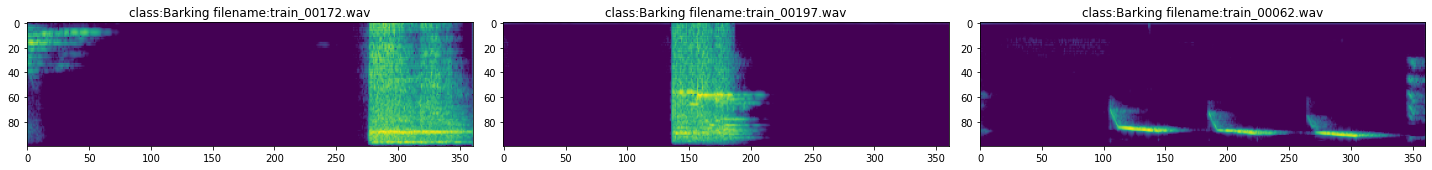

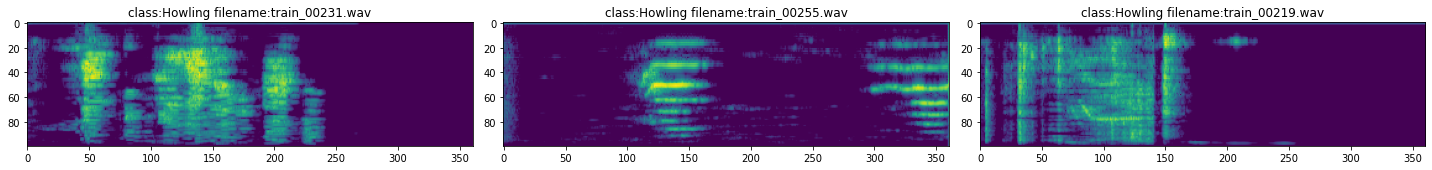

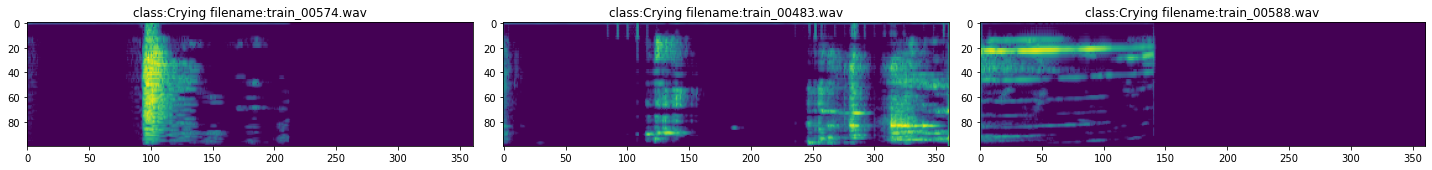

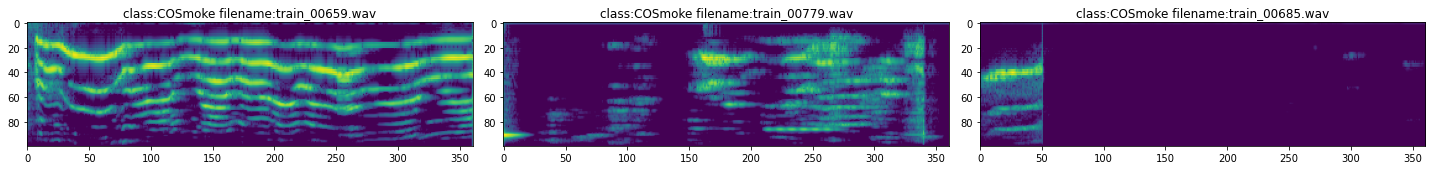

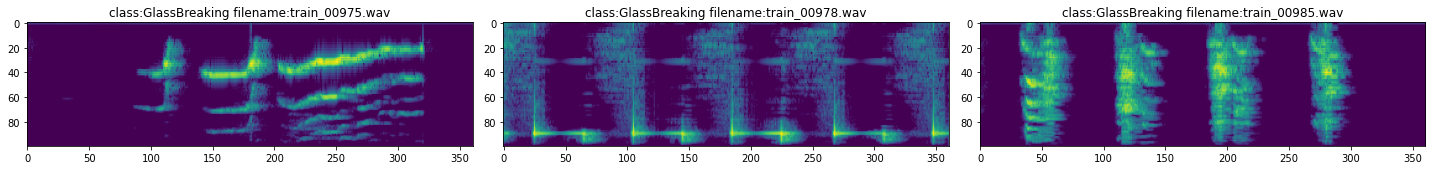

Other


<Figure size 1440x360 with 0 Axes>

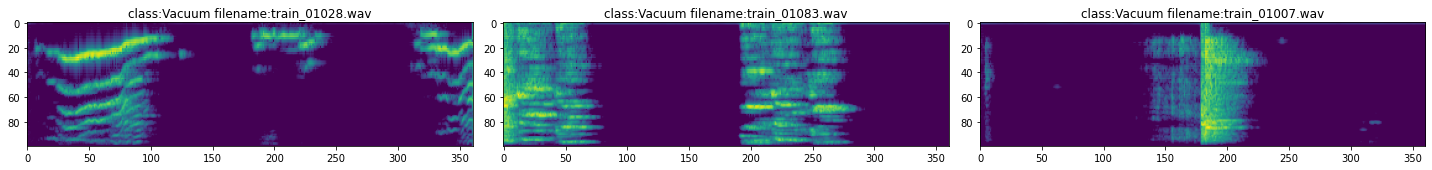

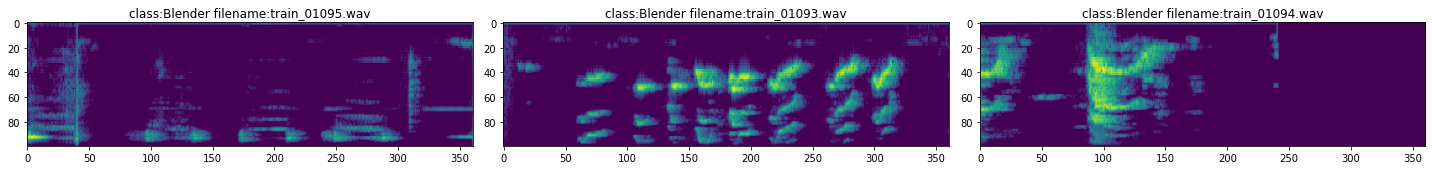

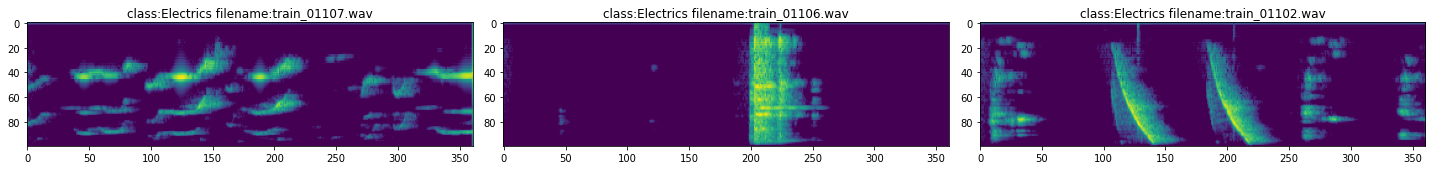

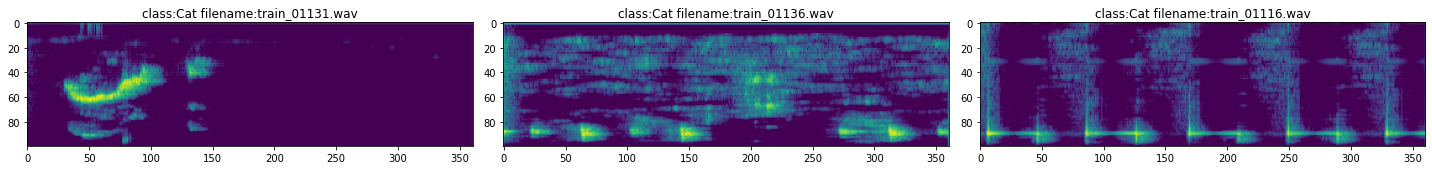

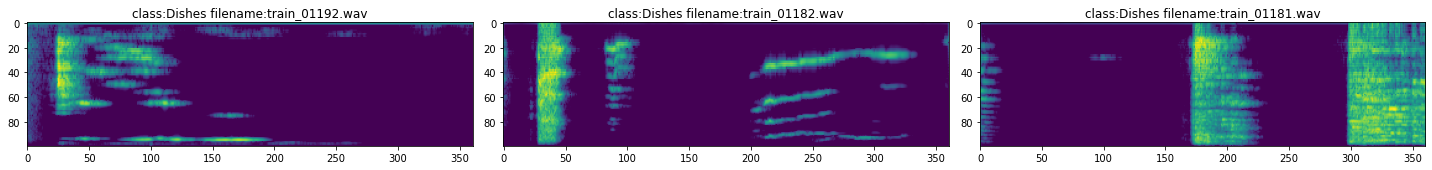

In [114]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

5    804
0    800
1    800
2    800
3    800
4    796
dtype: int64
5    201
0    200
1    200
2    200
3    200
4    199
dtype: int64


#  create pytorch dataloader and save

In [116]:
X_train = X_train.to(torch.float32)
X_valid = X_valid.to(torch.float32)

In [117]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=128,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=128,num_workers=4)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')

In [118]:
train_iter = torch.load('train_iter.pt')
vaild_iter = torch.load('vaild_iter.pt')

In [119]:
for bx,by in train_iter:
    print(bx.shape) # batch,channel,freq,time
    print(by.shape) # batch,n_class
    break

torch.Size([128, 1, 100, 361])
torch.Size([128, 6])


# define model

In [120]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*22*87,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,6)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,16*22*87)
        x = F.dropout(x,p=0.25)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.25)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p=0.25)
        x = F.softmax(self.fc3(x))
        return x
    
    def look_feature_map(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x
#model = LeNet()

# model forward test

In [121]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=6, bias=True)
y_hat = model(bx)
print(bx.shape)
print(y_hat.shape)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


torch.Size([128, 1, 100, 361])
torch.Size([128, 6])


# def train loop

In [123]:
def train_step(model,train_iter,loss_fn,optimizer):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,optimizer,loss_fn,max_epochs=300,log_interval=10):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model







  0%|          | 0/100 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  







  1%|          | 1/100 [00:07<12:50,  7.79s/it]

epoch:0 train_loss:0.4623 valid_loss:0.4563 train_auc:0.0000 valid_auc:0.0000








  2%|▏         | 2/100 [00:15<12:48,  7.84s/it]





  3%|▎         | 3/100 [00:23<12:35,  7.79s/it]





  4%|▍         | 4/100 [00:31<12:29,  7.81s/it]





  5%|▌         | 5/100 [00:39<12:23,  7.82s/it]





  6%|▌         | 6/100 [00:47<12:17,  7.85s/it]





  7%|▋         | 7/100 [00:54<12:01,  7.76s/it]





  8%|▊         | 8/100 [01:02<11:56,  7.79s/it]





  9%|▉         | 9/100 [01:10<11:45,  7.75s/it]





 10%|█         | 10/100 [01:17<11:33,  7.71s/it]





 11%|█         | 11/100 [01:25<11:28,  7.74s/it]

epoch:10 train_loss:0.0009 valid_loss:0.0030 train_auc:0.0000 valid_auc:0.0000








 12%|█▏        | 12/100 [01:33<11:15,  7.68s/it]





 13%|█▎        | 13/100 [01:41<11:38,  8.03s/it]





 14%|█▍        | 14/100 [01:49<11:23,  7.94s/it]





 15%|█▌        | 15/100 [01:57<11:06,  7.84s/it]





 16%|█▌        | 16/100 [02:05<11:00,  7.86s/it]





 17%|█▋        | 17/100 [02:12<10:47,  7.80s/it]





 18%|█▊        | 18/100 [02:20<10:40,  7.81s/it]





 19%|█▉        | 19/100 [02:28<10:27,  7.75s/it]





 20%|██        | 20/100 [02:35<10:18,  7.73s/it]





 21%|██        | 21/100 [02:43<10:14,  7.78s/it]

epoch:20 train_loss:0.0001 valid_loss:0.0023 train_auc:0.0000 valid_auc:0.0000








 22%|██▏       | 22/100 [02:51<10:04,  7.76s/it]





 23%|██▎       | 23/100 [02:59<09:58,  7.77s/it]





 24%|██▍       | 24/100 [03:07<09:52,  7.79s/it]





 25%|██▌       | 25/100 [03:14<09:38,  7.71s/it]





 26%|██▌       | 26/100 [03:22<09:34,  7.76s/it]





 27%|██▋       | 27/100 [03:30<09:27,  7.77s/it]





 28%|██▊       | 28/100 [03:39<09:40,  8.06s/it]





 29%|██▉       | 29/100 [03:47<09:31,  8.05s/it]





 30%|███       | 30/100 [03:55<09:22,  8.03s/it]





 31%|███       | 31/100 [04:03<09:13,  8.03s/it]

epoch:30 train_loss:0.0001 valid_loss:0.0022 train_auc:0.0000 valid_auc:0.0000








 32%|███▏      | 32/100 [04:10<08:57,  7.91s/it]





 33%|███▎      | 33/100 [04:18<08:51,  7.93s/it]





 34%|███▍      | 34/100 [04:26<08:40,  7.89s/it]





 35%|███▌      | 35/100 [04:34<08:30,  7.86s/it]





 36%|███▌      | 36/100 [04:42<08:19,  7.81s/it]





 37%|███▋      | 37/100 [04:49<08:12,  7.82s/it]





 38%|███▊      | 38/100 [04:57<08:05,  7.84s/it]





 39%|███▉      | 39/100 [05:05<08:00,  7.88s/it]





 40%|████      | 40/100 [05:13<07:50,  7.85s/it]





 41%|████      | 41/100 [05:21<07:43,  7.85s/it]

epoch:40 train_loss:0.0000 valid_loss:0.0023 train_auc:0.0000 valid_auc:0.0000








 42%|████▏     | 42/100 [05:28<07:30,  7.77s/it]





 43%|████▎     | 43/100 [05:36<07:19,  7.71s/it]





 44%|████▍     | 44/100 [05:45<07:30,  8.04s/it]





 45%|████▌     | 45/100 [05:53<07:16,  7.94s/it]





 46%|████▌     | 46/100 [06:01<07:11,  7.98s/it]





 47%|████▋     | 47/100 [06:08<06:59,  7.91s/it]





 48%|████▊     | 48/100 [06:16<06:48,  7.85s/it]





 49%|████▉     | 49/100 [06:24<06:38,  7.81s/it]





 50%|█████     | 50/100 [06:31<06:28,  7.77s/it]





 51%|█████     | 51/100 [06:39<06:21,  7.78s/it]

epoch:50 train_loss:0.0000 valid_loss:0.0024 train_auc:0.0000 valid_auc:0.0000








 52%|█████▏    | 52/100 [06:47<06:11,  7.73s/it]





 53%|█████▎    | 53/100 [06:55<06:04,  7.75s/it]





 54%|█████▍    | 54/100 [07:02<05:56,  7.76s/it]





 55%|█████▌    | 55/100 [07:10<05:47,  7.73s/it]





 56%|█████▌    | 56/100 [07:18<05:42,  7.79s/it]





 57%|█████▋    | 57/100 [07:26<05:33,  7.76s/it]





 58%|█████▊    | 58/100 [07:34<05:26,  7.77s/it]





 59%|█████▉    | 59/100 [07:41<05:20,  7.81s/it]





 60%|██████    | 60/100 [07:50<05:20,  8.01s/it]





 61%|██████    | 61/100 [07:58<05:10,  7.96s/it]

epoch:60 train_loss:0.0000 valid_loss:0.0025 train_auc:0.0000 valid_auc:0.0000








 62%|██████▏   | 62/100 [08:05<04:59,  7.88s/it]





 63%|██████▎   | 63/100 [08:13<04:51,  7.88s/it]





 64%|██████▍   | 64/100 [08:21<04:42,  7.83s/it]





 65%|██████▌   | 65/100 [08:29<04:31,  7.76s/it]





 66%|██████▌   | 66/100 [08:37<04:25,  7.80s/it]





 67%|██████▋   | 67/100 [08:44<04:15,  7.75s/it]





 68%|██████▊   | 68/100 [08:52<04:06,  7.69s/it]





 69%|██████▉   | 69/100 [08:59<03:58,  7.70s/it]





 70%|███████   | 70/100 [09:07<03:50,  7.69s/it]





 71%|███████   | 71/100 [09:15<03:43,  7.70s/it]

epoch:70 train_loss:0.0000 valid_loss:0.0026 train_auc:0.0000 valid_auc:0.0000








 72%|███████▏  | 72/100 [09:22<03:34,  7.65s/it]





 73%|███████▎  | 73/100 [09:30<03:27,  7.69s/it]





 74%|███████▍  | 74/100 [09:38<03:21,  7.75s/it]





 75%|███████▌  | 75/100 [09:46<03:18,  7.93s/it]





 76%|███████▌  | 76/100 [09:54<03:11,  7.98s/it]





 77%|███████▋  | 77/100 [10:02<03:02,  7.93s/it]





 78%|███████▊  | 78/100 [10:10<02:53,  7.88s/it]





 79%|███████▉  | 79/100 [10:18<02:46,  7.91s/it]





 80%|████████  | 80/100 [10:26<02:36,  7.85s/it]





 81%|████████  | 81/100 [10:34<02:29,  7.89s/it]

epoch:80 train_loss:0.0000 valid_loss:0.0027 train_auc:0.0000 valid_auc:0.0000








 82%|████████▏ | 82/100 [10:41<02:21,  7.83s/it]





 83%|████████▎ | 83/100 [10:49<02:13,  7.85s/it]





 84%|████████▍ | 84/100 [10:57<02:05,  7.84s/it]





 85%|████████▌ | 85/100 [11:05<01:56,  7.77s/it]





 86%|████████▌ | 86/100 [11:13<01:49,  7.85s/it]





 87%|████████▋ | 87/100 [11:21<01:41,  7.82s/it]





 88%|████████▊ | 88/100 [11:28<01:32,  7.74s/it]





 89%|████████▉ | 89/100 [11:36<01:25,  7.75s/it]





 90%|█████████ | 90/100 [11:44<01:17,  7.75s/it]





 91%|█████████ | 91/100 [11:52<01:12,  8.10s/it]

epoch:90 train_loss:0.0000 valid_loss:0.0028 train_auc:0.0000 valid_auc:0.0000








 92%|█████████▏| 92/100 [12:00<01:04,  8.05s/it]





 93%|█████████▎| 93/100 [12:09<00:56,  8.08s/it]





 94%|█████████▍| 94/100 [12:16<00:48,  8.01s/it]





 95%|█████████▌| 95/100 [12:24<00:39,  7.98s/it]





 96%|█████████▌| 96/100 [12:32<00:31,  7.89s/it]





 97%|█████████▋| 97/100 [12:40<00:23,  7.87s/it]





 98%|█████████▊| 98/100 [12:48<00:15,  7.91s/it]





 99%|█████████▉| 99/100 [12:56<00:07,  7.93s/it]





100%|██████████| 100/100 [13:04<00:00,  7.84s/it]


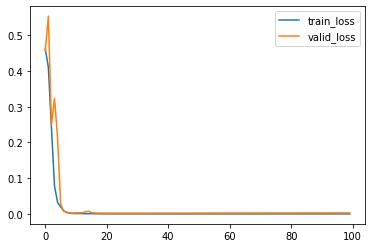

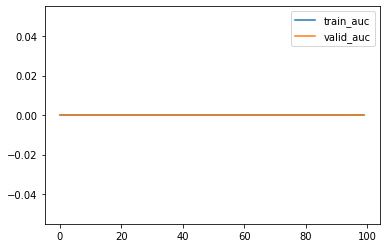

train done


In [124]:
device = 'cuda:0'
model = model.to(device)
print(model)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,optimizer,loss_fn,max_epochs=100,log_interval=10)
torch.save(model,'model.pt')
print('train done')

# model infernce test

In [125]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    return cm

In [126]:
cm = plot_confusion_matrix(model,train_iter)
cm.style.background_gradient()







  0%|          | 0/38 [00:00<?, ?it/s]





  3%|▎         | 1/38 [00:01<00:46,  1.26s/it]





 13%|█▎        | 5/38 [00:01<00:29,  1.12it/s]





 24%|██▎       | 9/38 [00:01<00:18,  1.58it/s]





 34%|███▍      | 13/38 [00:01<00:11,  2.22it/s]





 45%|████▍     | 17/38 [00:01<00:06,  3.08it/s]





 55%|█████▌    | 21/38 [00:01<00:04,  4.23it/s]





 66%|██████▌   | 25/38 [00:01<00:02,  5.73it/s]





 76%|███████▋  | 29/38 [00:02<00:01,  7.60it/s]





 87%|████████▋ | 33/38 [00:02<00:00,  9.92it/s]





100%|██████████| 38/38 [00:02<00:00, 14.28it/s]


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,797,0,0,0,0,0
1,0,800,3,0,0,0
2,0,0,797,0,0,0
3,3,0,0,800,0,0
4,0,0,0,0,796,0
5,0,0,0,0,0,804


In [127]:
cm = plot_confusion_matrix(model,vaild_iter)
cm.style.background_gradient()







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:01<00:11,  1.22s/it]





 40%|████      | 4/10 [00:01<00:05,  1.15it/s]





100%|██████████| 10/10 [00:01<00:00,  5.45it/s][A


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,198,0,0,0,0,0
1,0,200,2,0,0,0
2,0,0,198,0,0,0
3,2,0,0,200,0,0
4,0,0,0,0,199,0
5,0,0,0,0,0,201


In [128]:
model = model.to('cpu')
torch.save(model,'model.pt')
print('model save done')

model save done


# submit

In [ ]:
# load model
model = torch.load('model.pt').cuda()
print('use model is:',model)

# test_data_dir
test_data_dir = 'public_test/public_test/'

# inference for loop
files = os.listdir(test_data_dir)
n = 10000
sample_submit = pd.read_csv('sample_submission.csv')
i = 0
for f in tqdm(files[:n]):
    samples, sample_rate = librosa.load(test_data_dir+f,sr=16000)
    mel_spectrogram = sample2melspectrogram(samples,sample_rate)
    shape = mel_spectrogram.shape
    mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
    mel_spectrogram = torch.from_numpy(mel_spectrogram)
    X = torch.unsqueeze(mel_spectrogram,0).to(torch.float32).cuda()
    y_hat = model(X).detach().cpu().numpy()
    sample_submit.iloc[[i],1:] = y_hat
    i += 1
    gc.collect()

# save
sample_submit.to_csv('submit.csv',index=False)
print('done')







  0%|          | 0/10000 [00:00<?, ?it/s]

use model is: DataParallel(
  (module): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi







  0%|          | 1/10000 [00:00<1:02:20,  2.67it/s]





  0%|          | 2/10000 [00:00<55:22,  3.01it/s]  





  0%|          | 3/10000 [00:00<52:43,  3.16it/s]





  0%|          | 4/10000 [00:01<50:26,  3.30it/s]





  0%|          | 5/10000 [00:01<47:17,  3.52it/s]





  0%|          | 6/10000 [00:01<46:04,  3.62it/s]





  0%|          | 7/10000 [00:01<43:33,  3.82it/s]





  0%|          | 8/10000 [00:02<43:16,  3.85it/s]





  0%|          | 9/10000 [00:02<41:50,  3.98it/s]





  0%|          | 10/10000 [00:02<40:58,  4.06it/s]





  0%|          | 11/10000 [00:02<41:53,  3.97it/s]





  0%|          | 12/10000 [00:03<40:52,  4.07it/s]





  0%|          | 13/10000 [00:03<41:44,  3.99it/s]





  0%|          | 14/10000 [00:03<41:08,  4.04it/s]





  0%|          | 15/10000 [00:03<41:36,  4.00it/s]





  0%|          | 16/10000 [00:04<41:01,  4.06it/s]





  0%|          | 17/10000 [00:04<42:22,  3.93it/s]





  0%|          | 18/10000 [00:04<41:48,  3.98it

  1%|          | 111/10000 [00:27<37:06,  4.44it/s]





  1%|          | 112/10000 [00:27<36:15,  4.55it/s]





  1%|          | 113/10000 [00:27<35:56,  4.59it/s]





  1%|          | 114/10000 [00:28<35:44,  4.61it/s]





  1%|          | 115/10000 [00:28<34:59,  4.71it/s]





  1%|          | 116/10000 [00:28<36:34,  4.50it/s]





  1%|          | 117/10000 [00:28<36:05,  4.56it/s]





  1%|          | 118/10000 [00:28<35:30,  4.64it/s]





  1%|          | 119/10000 [00:29<34:51,  4.72it/s]





  1%|          | 120/10000 [00:29<34:56,  4.71it/s]





  1%|          | 121/10000 [00:29<34:58,  4.71it/s]





  1%|          | 122/10000 [00:29<34:53,  4.72it/s]





  1%|          | 123/10000 [00:30<36:25,  4.52it/s]





  1%|          | 124/10000 [00:30<35:38,  4.62it/s]





  1%|▏         | 125/10000 [00:30<35:06,  4.69it/s]





  1%|▏         | 126/10000 [00:30<35:07,  4.69it/s]





  1%|▏         | 127/10000 [00:30<34:37,  4.75it/s]





  1%|▏         | 128/10000 [00:

  2%|▏         | 220/10000 [00:50<34:21,  4.74it/s]





  2%|▏         | 221/10000 [00:51<34:15,  4.76it/s]





  2%|▏         | 222/10000 [00:51<34:16,  4.75it/s]





  2%|▏         | 223/10000 [00:51<34:01,  4.79it/s]





  2%|▏         | 224/10000 [00:51<33:57,  4.80it/s]





  2%|▏         | 225/10000 [00:51<36:15,  4.49it/s]





  2%|▏         | 226/10000 [00:52<35:30,  4.59it/s]





  2%|▏         | 227/10000 [00:52<35:06,  4.64it/s]





  2%|▏         | 228/10000 [00:52<34:19,  4.74it/s]





  2%|▏         | 229/10000 [00:52<34:02,  4.78it/s]





  2%|▏         | 230/10000 [00:52<33:54,  4.80it/s]





  2%|▏         | 231/10000 [00:53<33:54,  4.80it/s]





  2%|▏         | 232/10000 [00:53<33:57,  4.79it/s]





  2%|▏         | 233/10000 [00:53<34:50,  4.67it/s]





  2%|▏         | 234/10000 [00:53<34:31,  4.72it/s]





  2%|▏         | 235/10000 [00:54<34:01,  4.78it/s]





  2%|▏         | 236/10000 [00:54<33:37,  4.84it/s]





  2%|▏         | 237/10000 [00:

  3%|▎         | 329/10000 [01:13<33:36,  4.80it/s]





  3%|▎         | 330/10000 [01:13<34:29,  4.67it/s]





  3%|▎         | 331/10000 [01:14<34:15,  4.70it/s]





  3%|▎         | 332/10000 [01:14<34:23,  4.69it/s]





  3%|▎         | 333/10000 [01:14<34:35,  4.66it/s]





  3%|▎         | 334/10000 [01:14<34:05,  4.73it/s]





  3%|▎         | 335/10000 [01:14<33:36,  4.79it/s]





  3%|▎         | 336/10000 [01:15<33:16,  4.84it/s]





  3%|▎         | 337/10000 [01:15<33:43,  4.77it/s]





  3%|▎         | 338/10000 [01:15<33:20,  4.83it/s]





  3%|▎         | 339/10000 [01:15<32:58,  4.88it/s]





  3%|▎         | 340/10000 [01:15<32:53,  4.89it/s]





  3%|▎         | 341/10000 [01:16<33:03,  4.87it/s]





  3%|▎         | 342/10000 [01:16<35:08,  4.58it/s]





  3%|▎         | 343/10000 [01:16<34:46,  4.63it/s]





  3%|▎         | 344/10000 [01:16<34:23,  4.68it/s]





  3%|▎         | 345/10000 [01:17<38:26,  4.19it/s]





  3%|▎         | 346/10000 [01:

  4%|▍         | 438/10000 [01:37<32:41,  4.88it/s]





  4%|▍         | 439/10000 [01:37<33:07,  4.81it/s]





  4%|▍         | 440/10000 [01:37<35:29,  4.49it/s]





  4%|▍         | 441/10000 [01:37<36:17,  4.39it/s]





  4%|▍         | 442/10000 [01:38<38:18,  4.16it/s]





  4%|▍         | 443/10000 [01:38<38:23,  4.15it/s]





  4%|▍         | 444/10000 [01:38<39:17,  4.05it/s]





  4%|▍         | 445/10000 [01:38<38:59,  4.08it/s]





  4%|▍         | 446/10000 [01:39<39:37,  4.02it/s]





  4%|▍         | 447/10000 [01:39<39:17,  4.05it/s]





  4%|▍         | 448/10000 [01:39<39:53,  3.99it/s]





  4%|▍         | 449/10000 [01:39<39:22,  4.04it/s]





  4%|▍         | 450/10000 [01:40<40:54,  3.89it/s]





  5%|▍         | 451/10000 [01:40<41:58,  3.79it/s]





  5%|▍         | 452/10000 [01:40<40:23,  3.94it/s]





  5%|▍         | 453/10000 [01:40<41:05,  3.87it/s]





  5%|▍         | 454/10000 [01:41<39:54,  3.99it/s]





  5%|▍         | 455/10000 [01:

  5%|▌         | 547/10000 [02:02<35:41,  4.41it/s]





  5%|▌         | 548/10000 [02:03<34:15,  4.60it/s]





  5%|▌         | 549/10000 [02:03<34:05,  4.62it/s]





  6%|▌         | 550/10000 [02:03<33:23,  4.72it/s]





  6%|▌         | 551/10000 [02:03<33:00,  4.77it/s]





  6%|▌         | 552/10000 [02:03<32:39,  4.82it/s]





  6%|▌         | 553/10000 [02:04<32:06,  4.90it/s]





  6%|▌         | 554/10000 [02:04<31:50,  4.94it/s]





  6%|▌         | 555/10000 [02:04<31:51,  4.94it/s]





  6%|▌         | 556/10000 [02:04<32:44,  4.81it/s]





  6%|▌         | 557/10000 [02:04<33:51,  4.65it/s]





  6%|▌         | 558/10000 [02:05<33:43,  4.67it/s]





  6%|▌         | 559/10000 [02:05<33:30,  4.69it/s]





  6%|▌         | 560/10000 [02:05<33:36,  4.68it/s]





  6%|▌         | 561/10000 [02:05<33:35,  4.68it/s]





  6%|▌         | 562/10000 [02:06<33:52,  4.64it/s]





  6%|▌         | 563/10000 [02:06<34:50,  4.51it/s]





  6%|▌         | 564/10000 [02:

  7%|▋         | 656/10000 [02:29<38:31,  4.04it/s]





  7%|▋         | 657/10000 [02:29<39:04,  3.98it/s]





  7%|▋         | 658/10000 [02:29<37:53,  4.11it/s]





  7%|▋         | 659/10000 [02:30<38:47,  4.01it/s]





  7%|▋         | 660/10000 [02:30<37:59,  4.10it/s]





  7%|▋         | 661/10000 [02:30<39:13,  3.97it/s]





  7%|▋         | 662/10000 [02:30<37:57,  4.10it/s]





  7%|▋         | 663/10000 [02:31<39:03,  3.98it/s]





  7%|▋         | 664/10000 [02:31<39:59,  3.89it/s]





  7%|▋         | 665/10000 [02:31<39:15,  3.96it/s]





  7%|▋         | 666/10000 [02:32<39:26,  3.94it/s]





  7%|▋         | 667/10000 [02:32<39:01,  3.99it/s]





  7%|▋         | 668/10000 [02:32<39:21,  3.95it/s]





  7%|▋         | 669/10000 [02:32<39:41,  3.92it/s]





  7%|▋         | 670/10000 [02:32<37:30,  4.15it/s]





  7%|▋         | 671/10000 [02:33<38:39,  4.02it/s]





  7%|▋         | 672/10000 [02:33<37:57,  4.10it/s]





  7%|▋         | 673/10000 [02:

  8%|▊         | 765/10000 [02:55<37:25,  4.11it/s]





  8%|▊         | 766/10000 [02:55<36:30,  4.22it/s]





  8%|▊         | 767/10000 [02:55<36:57,  4.16it/s]





  8%|▊         | 768/10000 [02:55<36:22,  4.23it/s]





  8%|▊         | 769/10000 [02:56<37:36,  4.09it/s]





  8%|▊         | 770/10000 [02:56<37:00,  4.16it/s]





  8%|▊         | 771/10000 [02:56<35:13,  4.37it/s]





  8%|▊         | 772/10000 [02:56<34:09,  4.50it/s]





  8%|▊         | 773/10000 [02:56<34:30,  4.46it/s]





  8%|▊         | 774/10000 [02:57<33:23,  4.60it/s]





  8%|▊         | 775/10000 [02:57<35:27,  4.34it/s]





  8%|▊         | 776/10000 [02:57<34:15,  4.49it/s]





  8%|▊         | 777/10000 [02:57<35:11,  4.37it/s]





  8%|▊         | 778/10000 [02:58<34:15,  4.49it/s]





  8%|▊         | 779/10000 [02:58<36:21,  4.23it/s]





  8%|▊         | 780/10000 [02:58<35:10,  4.37it/s]





  8%|▊         | 781/10000 [02:58<37:04,  4.14it/s]





  8%|▊         | 782/10000 [02:

  9%|▊         | 874/10000 [03:21<38:00,  4.00it/s]





  9%|▉         | 875/10000 [03:21<37:44,  4.03it/s]





  9%|▉         | 876/10000 [03:22<38:15,  3.97it/s]





  9%|▉         | 877/10000 [03:22<37:30,  4.05it/s]





  9%|▉         | 878/10000 [03:22<39:12,  3.88it/s]





  9%|▉         | 879/10000 [03:23<39:39,  3.83it/s]





  9%|▉         | 880/10000 [03:23<38:53,  3.91it/s]





  9%|▉         | 881/10000 [03:23<40:21,  3.77it/s]





  9%|▉         | 882/10000 [03:23<40:30,  3.75it/s]





  9%|▉         | 883/10000 [03:24<39:10,  3.88it/s]





  9%|▉         | 884/10000 [03:24<39:58,  3.80it/s]





  9%|▉         | 885/10000 [03:24<38:58,  3.90it/s]





  9%|▉         | 886/10000 [03:24<39:00,  3.89it/s]





  9%|▉         | 887/10000 [03:25<38:00,  4.00it/s]





  9%|▉         | 888/10000 [03:25<38:11,  3.98it/s]





  9%|▉         | 889/10000 [03:25<38:23,  3.96it/s]





  9%|▉         | 890/10000 [03:25<38:36,  3.93it/s]





  9%|▉         | 891/10000 [03:

 10%|▉         | 983/10000 [03:47<33:19,  4.51it/s]





 10%|▉         | 984/10000 [03:47<32:48,  4.58it/s]





 10%|▉         | 985/10000 [03:47<33:10,  4.53it/s]





 10%|▉         | 986/10000 [03:47<35:34,  4.22it/s]





 10%|▉         | 987/10000 [03:48<35:43,  4.21it/s]





 10%|▉         | 988/10000 [03:48<34:19,  4.38it/s]





 10%|▉         | 989/10000 [03:48<36:01,  4.17it/s]





 10%|▉         | 990/10000 [03:48<34:46,  4.32it/s]





 10%|▉         | 991/10000 [03:48<36:20,  4.13it/s]





 10%|▉         | 992/10000 [03:49<34:44,  4.32it/s]





 10%|▉         | 993/10000 [03:49<35:20,  4.25it/s]





 10%|▉         | 994/10000 [03:49<36:05,  4.16it/s]





 10%|▉         | 995/10000 [03:49<36:04,  4.16it/s]





 10%|▉         | 996/10000 [03:50<36:02,  4.16it/s]





 10%|▉         | 997/10000 [03:50<35:15,  4.25it/s]





 10%|▉         | 998/10000 [03:50<35:26,  4.23it/s]





 10%|▉         | 999/10000 [03:50<36:32,  4.11it/s]





 10%|█         | 1000/10000 [03

 11%|█         | 1091/10000 [04:13<36:44,  4.04it/s]





 11%|█         | 1092/10000 [04:13<35:53,  4.14it/s]





 11%|█         | 1093/10000 [04:13<35:40,  4.16it/s]





 11%|█         | 1094/10000 [04:14<35:44,  4.15it/s]





 11%|█         | 1095/10000 [04:14<35:52,  4.14it/s]





 11%|█         | 1096/10000 [04:14<36:03,  4.12it/s]